In [316]:
import chainer
from chainer import Variable
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.optimizers import rmsprop

In [317]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


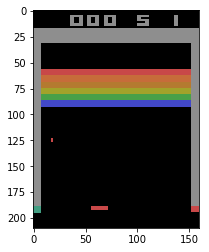

In [318]:
import gym


class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

env = gym.make('Breakout-v0')
print(env.unwrapped.get_action_meanings())

n_iter = 5
agent = RandomAgent(env.action_space)

env = gym.make('Breakout-v0')
obs = env.reset()  # reset environment and agent
reward = None
done = False
R = []

for step in range(n_iter):
    plt.imshow(env.render(mode='rgb_array'))
    action = agent.act(obs, reward, done)
    _obs, reward, done, _ = env.step(action)
    obs = _obs
    R.append(reward)

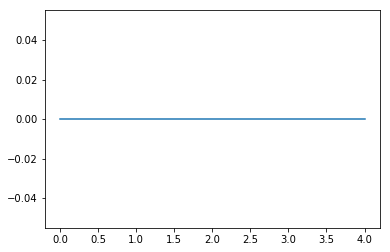

In [319]:
plt.plot(np.cumsum(R))

In [320]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.low[0][0])
print(env.observation_space.high[0][0])

Discrete(4)
Box(210, 160, 3)
[0 0 0]
[255 255 255]


In [321]:
env.observation_space.low.size
env.action_space.n

4

In [322]:
class MLP(Chain):
    
    def __init__(self, obs_size, n_units=64):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_units)
            self.l1 = L.Linear(n_units, 2 * n_units)
            self.l2 = L.Linear(2 * n_units, n_units)
            
    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return F.relu(self.l2(h))  

In [323]:
class ActorCritic(Chain):
    
    def __init__(self, shared_model, n_actions):
        super(ActorCritic, self).__init__()
        with self.init_scope():
            self.shared_model = shared_model
            
            self.actor = L.Linear(None, n_actions)
            self.critic = L.Linear(None, 1)
    
    
    def __call__(self, x):
        h = self.shared_model(x)
    
        pi = F.softmax(self.actor(h))
        v = self.critic(h)
        return pi, v

In [324]:
AC = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)

In [325]:
MLP(obs_size)(frame_preprocessor(obs))

variable([[ 0.        ,  0.        ,  0.0152206 ,  0.37986195,  0.27194846,
            0.16108681,  0.        ,  0.08610594,  0.09707208,  0.13369046,
            0.12673774,  0.11866187,  0.13152272,  0.0131299 ,  0.17112538,
            0.15876147,  0.        ,  0.05170199,  0.        ,  0.1211893 ,
            0.14073157,  0.        ,  0.16787861,  0.11687658,  0.07183771,
            0.08983315,  0.31045115,  0.02076956,  0.23540458,  0.        ,
            0.        ,  0.14566092,  0.        ,  0.18421844,  0.        ,
            0.        ,  0.        ,  0.26883575,  0.        ,  0.08964127,
            0.        ,  0.19141686,  0.        ,  0.        ,  0.09620921,
            0.07862966,  0.17524832,  0.09388117,  0.04381774,  0.        ,
            0.        ,  0.12127674,  0.        ,  0.0354233 ,  0.0559582 ,
            0.        ,  0.        ,  0.        ,  0.37064606,  0.        ,
            0.42838839,  0.        ,  0.        ,  0.        ]])

In [326]:
AC(frame_preprocessor(obs))

(variable([[ 0.21068718,  0.24864033,  0.24100947,  0.29966304]]),
 variable([[-0.05962345]]))

In [327]:
obs_shape = (2,3)
a = np.zeros([2 + 1, 5] + list(obs_shape))
print(a.shape, a.reshape([-1] + list(a.shape)).shape)

(3, 5, 2, 3) (1, 3, 5, 2, 3)


_compute_returns illustration

In [328]:
update_steps = 5
gamma = 0.99
returns = np.zeros(update_steps + 1)
rewards = [1, 1, 1, 1, 1]
next_val = 9
returns[-1] = next_val 
for i in reversed(range(update_steps)):
    returns[i] = rewards[i] + gamma * returns[i + 1]

print(returns)

[ 13.45990546  12.58576309  11.702791    10.8109       9.91         9.        ]


In [329]:
a = np.zeros((1,4))
a.flatten().shape

(4,)

In [339]:
class A2CAgent(object):
    
    def __init__(self, model, optimizer, n_steps, gamma, phi=lambda x: x, 
                 pi_loss_coef=1.0, v_loss_coef=0.5,
                 average_actor_loss_decay=0.999,
                 average_value_decay=0.999,
                ):
        
        self.model = model
        self.optimizer = optimizer
        self.n_steps = n_steps
        self.gamma = gamma
        self.phi = phi
        self.pi_loss_coef = pi_loss_coef
        self.v_loss_coef = v_loss_coef
    
        self.step = 0
        self.start_step = 0
    
        self.average_actor_loss_decay = average_actor_loss_decay
        self.average_value_decay = average_value_decay
    
        # Stats
        self.average_actor_loss = 0
        self.average_value = 0
    
    def _compute_returns(self, next_value):
        
        self.returns[-1] = next_value
        for i in reversed(range(self.n_steps)):
            self.returns[i] = self.rewards[i] + \
                self.gamma * self.returns[i + 1]
    
    def _reset_storage(self, state, p_out):
        
#         self.states = self.xp.zeros(
#             [self.update_steps + 1, self.num_processes] + list(obs_shape),
#             dtype='f')
#         self.actions = self.xp.zeros(
#             [self.update_steps, self.num_processes] + list(action_shape),
#             dtype=action.dtype)
#         self.rewards = self.xp.zeros(
#             (self.update_steps, self.num_processes, 1), dtype='f')
#         self.value_preds = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')
#         self.returns = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')

        self.states = np.zeros((self.n_steps + 1,) + state.shape, dtype=np.float32)
        self.action_log_probs = np.zeros(self.n_steps, dtype=np.float32)
        self.rewards = np.zeros(self.n_steps, dtype=np.float32)
        self.value_preds = np.zeros(self.n_steps + 1, dtype=np.float32)
        self.returns = np.zeros(self.n_steps + 1, dtype=np.float32)
    
    def update(self):
        #print(len(self.states), len(self.actions), len(self.rewards), len(self.value_preds), len(self.returns))
        
        # print(np.dtype(self.states.flatten()[0]))
        
        # print(type(self.states[-1].flatten()[0]))
        _, next_value = self.model(self.states[-1])
        next_value = next_value.data

        self._compute_returns(next_value)
#         pout, values = \
#             self.model.pi_and_v(chainer.Variable(
#                 self.states[:-1].reshape([-1] + list(self.obs_shape))))
        p_out, values = self.model(chainer.Variable(self.states[:-1]))

#         actions = chainer.Variable(
#             self.actions.reshape([-1] + list(self.action_shape)))
#         dist_entropy = F.mean(pout.entropy)
#         action_log_probs = pout.log_prob(actions)
        # dist_entropy = ???
        
#         values = values.reshape(self.update_steps, self.num_processes, 1)
#         action_log_probs = action_log_probs.reshape(
#             self.update_steps, self.num_processes, 1)
#         advantages = chainer.Variable(self.returns[:-1]) - values
        # print(self.returns.shape)
        advantages = chainer.Variable(self.returns[:-1].reshape(-1, 1)) - values
        value_loss = F.mean(advantages * advantages)
        action_loss = - F.mean(chainer.Variable(advantages.data) * self.action_log_probs.reshape(-1, 1))
        
        self.model.cleargrads()

        (value_loss * self.v_loss_coef +
         action_loss * self.pi_loss_coef).backward()
         # - dist_entropy * self.entropy_coeff).backward()

        self.optimizer.update()
        self.states[0] = self.states[-1]

        # Update stats
        self.average_actor_loss += (
            (1 - self.average_actor_loss_decay) *
            (float(action_loss.data) - self.average_actor_loss))
        self.average_value += (
            (1 - self.average_value_decay) *
            (float(value_loss.data) - self.average_value))
#         self.average_entropy += (
#             (1 - self.average_entropy_decay) *
#             (float(dist_entropy.data) - self.average_entropy))
        self.start_step = self.step
    
    
    def act_and_train(self, state, reward, done):

#         statevar = self.batch_states([state], self.xp, self.phi)[0]
        state = self.phi(state)
        
        if self.step == 0:
#             pout, _ = self.model.pi_and_v(statevar[0:1])
#             action = pout.sample().data
            p_out, _ = self.model(state)
            action = np.random.choice(n_actions, p=p_out.data.flatten())
            self._reset_storage(state, p_out)
        
#         self.rewards[self.t - self.t_start -1] \
#             = self.xp.array(reward, dtype=self.xp.float32)
#         self.states[self.t - self.t_start] = statevar
    
        # self.rewards.append(reward)
        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        # self.states.append(state)
        #print( type(state))
        self.states[self.step - self.start_step] = state

        if self.step - self.start_step == self.n_steps:
            self.update()
            
        p_out, value = self.model(state)
        action = np.random.choice(n_actions, p=p_out.data.flatten())
        # action = env.action_space.sample()  # random
        
#         self.actions[self.t - self.t_start] \
#             = action.reshape([-1] + list(self.action_shape))
#         self.value_preds[self.t - self.t_start] = value.data
        self.action_log_probs[self.step - self.start_step] = F.log(p_out)[0][action].data
        # self.actions.append(action) 
        self.value_preds[self.step - self.start_step] = value.data
        # self.value_preds.append(0)

        self.step += 1
            
        return action
        # return env.action_space.sample()  # random
    
    def act(self, obs):

        pass
    
    def stop_episode_and_train(self, state, reward, done=False):
        
        state = phi(state)
        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        self.states[self.step - self.start_step] = state

        self.update()
#         if done:
#             self.update(None)
#         else:
#             state = self.phi(state)

#             self.update(state)
            
    def get_statistics(self):
        return [
            ('average_actor_loss', self.average_actor_loss),
            ('average_value', self.average_value),
        ]

/home/galias/miniconda2/envs/gym/lib/python3.6/site-packages/chainer/functions/math/exponential.py:51: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),


episode: 1 R: 0.0 statistics: [('average_actor_loss', 8.203524547296747e-06), ('average_value', 3088.669954311215)]
episode: 2 R: 0.0 statistics: [('average_actor_loss', 7.905401116745408e-06), ('average_value', 2976.4224238777397)]
episode: 3 R: 0.0 statistics: [('average_actor_loss', 7.180986439717089e-06), ('average_value', 2871.1252852999014)]
episode: 4 R: 1.0 statistics: [('average_actor_loss', 0.00042498496495772516), ('average_value', 2752.9778073995208)]
episode: 5 R: 2.0 statistics: [('average_actor_loss', 0.001125655483935707), ('average_value', 2608.1898678484704)]
episode: 6 R: 3.0 statistics: [('average_actor_loss', 0.0022609134643614454), ('average_value', 2439.086557175695)]
episode: 7 R: 2.0 statistics: [('average_actor_loss', 0.0029009780628014466), ('average_value', 2287.8039350309577)]
episode: 8 R: 3.0 statistics: [('average_actor_loss', 0.0038943847623502106), ('average_value', 2148.052888981413)]
episode: 9 R: 3.0 statistics: [('average_actor_loss', 0.00303305815

episode: 72 R: 2.0 statistics: [('average_actor_loss', 0.004904131926293194), ('average_value', 95.00219676304151)]
episode: 73 R: 2.0 statistics: [('average_actor_loss', 0.00502454720020928), ('average_value', 90.2773676840075)]
episode: 74 R: 0.0 statistics: [('average_actor_loss', 0.004096459361368432), ('average_value', 87.17079919274339)]
episode: 75 R: 0.0 statistics: [('average_actor_loss', 0.0033211244531452964), ('average_value', 84.08695784903895)]
episode: 76 R: 1.0 statistics: [('average_actor_loss', 0.0033877575171409715), ('average_value', 80.54669872155834)]
episode: 77 R: 2.0 statistics: [('average_actor_loss', 0.003975442091089584), ('average_value', 75.77919680632077)]
episode: 78 R: 1.0 statistics: [('average_actor_loss', 0.003131136809584634), ('average_value', 71.93770528351732)]
episode: 79 R: 0.0 statistics: [('average_actor_loss', 0.0025464549263318603), ('average_value', 69.53175757545037)]
episode: 80 R: 0.0 statistics: [('average_actor_loss', 0.00210988133637

episode: 142 R: 3.0 statistics: [('average_actor_loss', 0.004669186785737533), ('average_value', 2.7935441029064076)]
episode: 143 R: 1.0 statistics: [('average_actor_loss', 0.003677810125106807), ('average_value', 2.670762946171169)]
episode: 144 R: 3.0 statistics: [('average_actor_loss', 0.0037621654156117464), ('average_value', 2.493900410099802)]
episode: 145 R: 1.0 statistics: [('average_actor_loss', 0.0033175737423645824), ('average_value', 2.3775234646682413)]
episode: 146 R: 0.0 statistics: [('average_actor_loss', 0.002535399213814904), ('average_value', 2.295717565266366)]
episode: 147 R: 2.0 statistics: [('average_actor_loss', 0.003616825053670181), ('average_value', 2.167940059380914)]
episode: 148 R: 3.0 statistics: [('average_actor_loss', 0.00588019859515953), ('average_value', 2.0402798132842013)]
episode: 149 R: 4.0 statistics: [('average_actor_loss', 0.008237299060012184), ('average_value', 1.8981204377186407)]
episode: 150 R: 0.0 statistics: [('average_actor_loss', 0.0

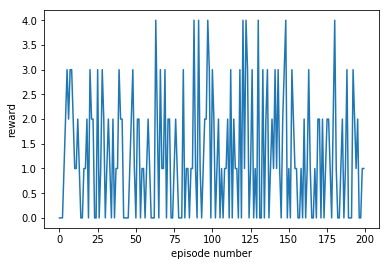

In [341]:
env = gym.make('Breakout-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5
n_episodes = 200

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

rewards_per_episode = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    #if i % 10 == 0:
    print('episode:', i,
          'R:', R,
          'statistics:', agent.get_statistics()
         )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')
plt.plot(rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 1 R: 27.0 statistics: [('average_actor_loss', 0.004874027453291808), ('average_value', 0.05977872442082376)]
episode: 2 R: 25.0 statistics: [('average_actor_loss', 0.006851966821493888), ('average_value', 0.061895091507222964)]
episode: 3 R: 16.0 statistics: [('average_actor_loss', 0.007051349913998002), ('average_value', 0.061695173875951186)]
episode: 4 R: 14.0 statistics: [('average_actor_loss', 0.0070540598886571345), ('average_value', 0.06151107760598843)]
episode: 5 R: 9.0 statistics: [('average_actor_loss', 0.007042189829705912), ('average_value', 0.06138871560264642)]
episode: 6 R: 18.0 statistics: [('average_actor_loss', 0.007009045527633001), ('average_value', 0.061143801141778864)]
episode: 7 R: 31.0 statistics: [('average_actor_loss', 0.006950092209435174), ('average_value', 0.06071733085040726)]
episode: 8 R: 16.0 statistics: [('average_actor_loss', 0.006929115018609

episode: 72 R: 9.0 statistics: [('average_actor_loss', 0.005213965205975792), ('average_value', 0.045655621292324096)]
episode: 73 R: 28.0 statistics: [('average_actor_loss', 0.005186604177265179), ('average_value', 0.0453826023354253)]
episode: 74 R: 16.0 statistics: [('average_actor_loss', 0.0051661263102166), ('average_value', 0.045201647717354174)]
episode: 75 R: 14.0 statistics: [('average_actor_loss', 0.0051466154924141305), ('average_value', 0.0450662807751568)]
episode: 76 R: 11.0 statistics: [('average_actor_loss', 0.005133464310948512), ('average_value', 0.044931251194705986)]
episode: 77 R: 13.0 statistics: [('average_actor_loss', 0.005115878860973887), ('average_value', 0.04479664821289256)]
episode: 78 R: 35.0 statistics: [('average_actor_loss', 0.005085865531320954), ('average_value', 0.04448511345387709)]
episode: 79 R: 23.0 statistics: [('average_actor_loss', 0.005031879809052294), ('average_value', 0.04426625794085186)]
episode: 80 R: 11.0 statistics: [('average_actor_

episode: 142 R: 14.0 statistics: [('average_actor_loss', 0.005637477832611435), ('average_value', 0.04954793686769125)]
episode: 143 R: 10.0 statistics: [('average_actor_loss', 0.005653709254959601), ('average_value', 0.049492144587477443)]
episode: 144 R: 13.0 statistics: [('average_actor_loss', 0.005945860090387639), ('average_value', 0.04948250624833147)]
episode: 145 R: 10.0 statistics: [('average_actor_loss', 0.0059240354420942104), ('average_value', 0.04942526458168309)]
episode: 146 R: 13.0 statistics: [('average_actor_loss', 0.005913588168577471), ('average_value', 0.04934301573010431)]
episode: 147 R: 18.0 statistics: [('average_actor_loss', 0.005939422559140336), ('average_value', 0.04974306017515288)]
episode: 148 R: 14.0 statistics: [('average_actor_loss', 0.006098023365967543), ('average_value', 0.05021206037485273)]
episode: 149 R: 9.0 statistics: [('average_actor_loss', 0.006014715128741975), ('average_value', 0.05049780791442692)]
episode: 150 R: 13.0 statistics: [('ave

episode: 213 R: 9.0 statistics: [('average_actor_loss', 0.005413831199255798), ('average_value', 0.050368202367943864)]
episode: 214 R: 8.0 statistics: [('average_actor_loss', 0.005387636286996845), ('average_value', 0.05036917060756062)]
episode: 215 R: 11.0 statistics: [('average_actor_loss', 0.005239350681138841), ('average_value', 0.050853708382904955)]
episode: 216 R: 8.0 statistics: [('average_actor_loss', 0.005223720310378573), ('average_value', 0.050859596543358275)]
episode: 217 R: 8.0 statistics: [('average_actor_loss', 0.005205679956771383), ('average_value', 0.05076436220212311)]
episode: 218 R: 9.0 statistics: [('average_actor_loss', 0.005189989304774766), ('average_value', 0.050720227686391194)]
episode: 219 R: 11.0 statistics: [('average_actor_loss', 0.005174598389979959), ('average_value', 0.05083458140833176)]
episode: 220 R: 9.0 statistics: [('average_actor_loss', 0.005208552604205728), ('average_value', 0.050829190470706186)]
episode: 221 R: 9.0 statistics: [('averag

episode: 286 R: 10.0 statistics: [('average_actor_loss', 0.004715576278778747), ('average_value', 0.05061696435942718)]
episode: 287 R: 9.0 statistics: [('average_actor_loss', 0.004840742049380136), ('average_value', 0.05054666677957094)]
episode: 288 R: 9.0 statistics: [('average_actor_loss', 0.004832108061646477), ('average_value', 0.05047028555907296)]
episode: 289 R: 12.0 statistics: [('average_actor_loss', 0.004792093665509288), ('average_value', 0.05033400326801952)]
episode: 290 R: 12.0 statistics: [('average_actor_loss', 0.004772424277497289), ('average_value', 0.050209750776000636)]
episode: 291 R: 8.0 statistics: [('average_actor_loss', 0.004763065461806837), ('average_value', 0.05011441228765771)]
episode: 292 R: 10.0 statistics: [('average_actor_loss', 0.004774980586991541), ('average_value', 0.05001668340373755)]
episode: 293 R: 10.0 statistics: [('average_actor_loss', 0.00476481922015913), ('average_value', 0.04992541122648989)]
episode: 294 R: 10.0 statistics: [('average

episode: 358 R: 8.0 statistics: [('average_actor_loss', 0.005190293323795285), ('average_value', 0.04895603853826475)]
episode: 359 R: 9.0 statistics: [('average_actor_loss', 0.005181001938775944), ('average_value', 0.04898840184709153)]
episode: 360 R: 9.0 statistics: [('average_actor_loss', 0.005173250454184611), ('average_value', 0.0490404859906218)]
episode: 361 R: 9.0 statistics: [('average_actor_loss', 0.005165409867662025), ('average_value', 0.04901788892451929)]
episode: 362 R: 10.0 statistics: [('average_actor_loss', 0.005266917911610904), ('average_value', 0.04892796066828486)]
episode: 363 R: 10.0 statistics: [('average_actor_loss', 0.0052559644680966215), ('average_value', 0.048831541892371724)]
episode: 364 R: 9.0 statistics: [('average_actor_loss', 0.005245063449546508), ('average_value', 0.04874907464177534)]
episode: 365 R: 9.0 statistics: [('average_actor_loss', 0.005236895430915755), ('average_value', 0.04867419610132787)]
episode: 366 R: 9.0 statistics: [('average_ac

episode: 428 R: 10.0 statistics: [('average_actor_loss', 0.0043599833130101755), ('average_value', 0.04862188857109194)]
episode: 429 R: 10.0 statistics: [('average_actor_loss', 0.004351664848867386), ('average_value', 0.048595129311534604)]
episode: 430 R: 10.0 statistics: [('average_actor_loss', 0.004343216821086555), ('average_value', 0.04854757841572431)]
episode: 431 R: 10.0 statistics: [('average_actor_loss', 0.004334669449022398), ('average_value', 0.04848471493265637)]
episode: 432 R: 8.0 statistics: [('average_actor_loss', 0.004326054036722696), ('average_value', 0.0484108685490898)]
episode: 433 R: 10.0 statistics: [('average_actor_loss', 0.0043170507943618205), ('average_value', 0.048317723675404385)]
episode: 434 R: 9.0 statistics: [('average_actor_loss', 0.004308294707295594), ('average_value', 0.04822129019038581)]
episode: 435 R: 9.0 statistics: [('average_actor_loss', 0.004299181319690743), ('average_value', 0.04815398652831971)]
episode: 436 R: 10.0 statistics: [('aver

episode: 502 R: 9.0 statistics: [('average_actor_loss', 0.003722345318933352), ('average_value', 0.04739487326455029)]
episode: 503 R: 9.0 statistics: [('average_actor_loss', 0.003714546593433798), ('average_value', 0.047326808933212255)]
episode: 504 R: 9.0 statistics: [('average_actor_loss', 0.0037073434949602183), ('average_value', 0.04740467196783878)]
episode: 505 R: 9.0 statistics: [('average_actor_loss', 0.003701381041020099), ('average_value', 0.04764080734194637)]
episode: 506 R: 9.0 statistics: [('average_actor_loss', 0.0036955517261982544), ('average_value', 0.047785548519861984)]
episode: 507 R: 10.0 statistics: [('average_actor_loss', 0.003688866383133574), ('average_value', 0.047731386249532944)]
episode: 508 R: 10.0 statistics: [('average_actor_loss', 0.0036814334130541217), ('average_value', 0.04764559069060326)]
episode: 509 R: 9.0 statistics: [('average_actor_loss', 0.0036740891358225864), ('average_value', 0.04758149517986071)]
episode: 510 R: 9.0 statistics: [('aver

episode: 573 R: 10.0 statistics: [('average_actor_loss', 0.0032419254038002464), ('average_value', 0.04705769387975909)]
episode: 574 R: 8.0 statistics: [('average_actor_loss', 0.003235444307372588), ('average_value', 0.04697717733699814)]
episode: 575 R: 10.0 statistics: [('average_actor_loss', 0.003228951006112464), ('average_value', 0.04688783727414978)]
episode: 576 R: 10.0 statistics: [('average_actor_loss', 0.0032224789777031745), ('average_value', 0.04679542945513845)]
episode: 577 R: 9.0 statistics: [('average_actor_loss', 0.003239695012129466), ('average_value', 0.046702296299158515)]
episode: 578 R: 10.0 statistics: [('average_actor_loss', 0.003233143310129633), ('average_value', 0.04661197468787503)]
episode: 579 R: 9.0 statistics: [('average_actor_loss', 0.003226678582802409), ('average_value', 0.04653013958932719)]
episode: 580 R: 10.0 statistics: [('average_actor_loss', 0.00322023711221532), ('average_value', 0.0464724925772571)]
episode: 581 R: 10.0 statistics: [('averag

episode: 646 R: 9.0 statistics: [('average_actor_loss', 0.0028278366390513954), ('average_value', 0.04592308860582605)]
episode: 647 R: 10.0 statistics: [('average_actor_loss', 0.0028222504734595243), ('average_value', 0.04583679010194287)]
episode: 648 R: 10.0 statistics: [('average_actor_loss', 0.0028166039897609208), ('average_value', 0.045749852177438946)]
episode: 649 R: 8.0 statistics: [('average_actor_loss', 0.0028109658379265137), ('average_value', 0.0456598885671952)]
episode: 650 R: 8.0 statistics: [('average_actor_loss', 0.0028054037322058994), ('average_value', 0.045586786853219756)]
episode: 651 R: 10.0 statistics: [('average_actor_loss', 0.0027999095610016164), ('average_value', 0.04556978498388726)]
episode: 652 R: 9.0 statistics: [('average_actor_loss', 0.0027944440365588264), ('average_value', 0.04558307707390486)]
episode: 653 R: 10.0 statistics: [('average_actor_loss', 0.0027889460433748385), ('average_value', 0.045579758952664)]
episode: 654 R: 10.0 statistics: [('a

episode: 715 R: 10.0 statistics: [('average_actor_loss', 0.002678851701282528), ('average_value', 0.044905378677165424)]
episode: 716 R: 10.0 statistics: [('average_actor_loss', 0.0026735833392000337), ('average_value', 0.04495587502710247)]
episode: 717 R: 9.0 statistics: [('average_actor_loss', 0.0026683392123740654), ('average_value', 0.045031078541690556)]
episode: 718 R: 11.0 statistics: [('average_actor_loss', 0.0026604488030740137), ('average_value', 0.04494409567011836)]
episode: 719 R: 10.0 statistics: [('average_actor_loss', 0.002655167974949455), ('average_value', 0.04490858396815222)]
episode: 720 R: 9.0 statistics: [('average_actor_loss', 0.0026498799098644233), ('average_value', 0.0448633986738821)]
episode: 721 R: 10.0 statistics: [('average_actor_loss', 0.002644722133863835), ('average_value', 0.04497189365459514)]
episode: 722 R: 8.0 statistics: [('average_actor_loss', 0.002639523220186176), ('average_value', 0.04505406639664182)]
episode: 723 R: 9.0 statistics: [('ave

episode: 786 R: 10.0 statistics: [('average_actor_loss', 0.0023173264723735324), ('average_value', 0.04505382589113738)]
episode: 787 R: 9.0 statistics: [('average_actor_loss', 0.0023126980818327725), ('average_value', 0.04497152459772388)]
episode: 788 R: 10.0 statistics: [('average_actor_loss', 0.0023080778282496646), ('average_value', 0.044884495698101136)]
episode: 789 R: 8.0 statistics: [('average_actor_loss', 0.002303464294233946), ('average_value', 0.04479691912433752)]
episode: 790 R: 9.0 statistics: [('average_actor_loss', 0.002298861912478967), ('average_value', 0.044707817373438596)]
episode: 791 R: 8.0 statistics: [('average_actor_loss', 0.0022942685601582825), ('average_value', 0.04461920355876076)]
episode: 792 R: 10.0 statistics: [('average_actor_loss', 0.0022896832344345614), ('average_value', 0.04453215634690306)]
episode: 793 R: 8.0 statistics: [('average_actor_loss', 0.0022851044392972085), ('average_value', 0.044443690278004)]
episode: 794 R: 8.0 statistics: [('aver

episode: 857 R: 9.0 statistics: [('average_actor_loss', 0.002003321092055726), ('average_value', 0.043202665507161106)]
episode: 858 R: 10.0 statistics: [('average_actor_loss', 0.001999325036651455), ('average_value', 0.0431438619756282)]
episode: 859 R: 9.0 statistics: [('average_actor_loss', 0.0019953297491316093), ('average_value', 0.04308136992174861)]
episode: 860 R: 9.0 statistics: [('average_actor_loss', 0.0019913524000785606), ('average_value', 0.0430675180631647)]
episode: 861 R: 10.0 statistics: [('average_actor_loss', 0.0019873854880977843), ('average_value', 0.04309290489874242)]
episode: 862 R: 9.0 statistics: [('average_actor_loss', 0.0019834187525749817), ('average_value', 0.043072082651411804)]
episode: 863 R: 9.0 statistics: [('average_actor_loss', 0.001979452405267606), ('average_value', 0.0430007427236224)]
episode: 864 R: 10.0 statistics: [('average_actor_loss', 0.0019754922062626638), ('average_value', 0.04291891039442344)]
episode: 865 R: 10.0 statistics: [('avera

episode: 928 R: 10.0 statistics: [('average_actor_loss', 0.0017348632563818722), ('average_value', 0.041195560654445226)]
episode: 929 R: 10.0 statistics: [('average_actor_loss', 0.0017314032025560798), ('average_value', 0.04121632679595749)]
episode: 930 R: 10.0 statistics: [('average_actor_loss', 0.0017279494627027712), ('average_value', 0.04123650342583698)]
episode: 931 R: 10.0 statistics: [('average_actor_loss', 0.0017245022060120364), ('average_value', 0.041258760564546255)]
episode: 932 R: 11.0 statistics: [('average_actor_loss', 0.0017193508431024168), ('average_value', 0.04131250478424336)]
episode: 933 R: 10.0 statistics: [('average_actor_loss', 0.0017159212291100042), ('average_value', 0.041439244642567215)]
episode: 934 R: 9.0 statistics: [('average_actor_loss', 0.0017124966801467581), ('average_value', 0.04147133295427178)]
episode: 935 R: 10.0 statistics: [('average_actor_loss', 0.0017090791173260042), ('average_value', 0.041496491404656055)]
episode: 936 R: 10.0 statisti

episode: 998 R: 9.0 statistics: [('average_actor_loss', 0.0015037830168964197), ('average_value', 0.039779050369030476)]
episode: 999 R: 10.0 statistics: [('average_actor_loss', 0.0015007787293920098), ('average_value', 0.0397437140716373)]
episode: 1000 R: 10.0 statistics: [('average_actor_loss', 0.0014977799352962828), ('average_value', 0.03970562123704768)]
episode: 1001 R: 9.0 statistics: [('average_actor_loss', 0.001494786768772244), ('average_value', 0.039656512106812224)]
episode: 1002 R: 8.0 statistics: [('average_actor_loss', 0.001491798382337048), ('average_value', 0.03958518827423937)]
episode: 1003 R: 8.0 statistics: [('average_actor_loss', 0.0014888156972509405), ('average_value', 0.03950910436283208)]
episode: 1004 R: 9.0 statistics: [('average_actor_loss', 0.0014858396478574217), ('average_value', 0.0394589583823347)]
episode: 1005 R: 11.0 statistics: [('average_actor_loss', 0.0014813945085599526), ('average_value', 0.03948426415989526)]
episode: 1006 R: 10.0 statistics:

episode: 1068 R: 10.0 statistics: [('average_actor_loss', 0.0013060143888586197), ('average_value', 0.03765584963293277)]
episode: 1069 R: 10.0 statistics: [('average_actor_loss', 0.0013034043158982377), ('average_value', 0.03761463992951192)]
episode: 1070 R: 10.0 statistics: [('average_actor_loss', 0.0013008003005943777), ('average_value', 0.03761107840008979)]
episode: 1071 R: 9.0 statistics: [('average_actor_loss', 0.0012982031824327548), ('average_value', 0.03767339556261478)]
episode: 1072 R: 10.0 statistics: [('average_actor_loss', 0.001295612420346126), ('average_value', 0.037729811454959794)]
episode: 1073 R: 10.0 statistics: [('average_actor_loss', 0.001293025204664202), ('average_value', 0.037789206017568286)]
episode: 1074 R: 8.0 statistics: [('average_actor_loss', 0.0012904447241323604), ('average_value', 0.03790820152115162)]
episode: 1075 R: 8.0 statistics: [('average_actor_loss', 0.0012878679248734032), ('average_value', 0.037881635729554664)]
episode: 1076 R: 11.0 stat

episode: 1136 R: 8.0 statistics: [('average_actor_loss', 0.0011319899165328), ('average_value', 0.036298732252037155)]
episode: 1137 R: 10.0 statistics: [('average_actor_loss', 0.0011297269829998317), ('average_value', 0.036233264688167816)]
episode: 1138 R: 10.0 statistics: [('average_actor_loss', 0.0011274686669157938), ('average_value', 0.036163671772329556)]
episode: 1139 R: 10.0 statistics: [('average_actor_loss', 0.0011252148562645719), ('average_value', 0.036093095455114264)]
episode: 1140 R: 10.0 statistics: [('average_actor_loss', 0.0011229655410267855), ('average_value', 0.036021967961090876)]
episode: 1141 R: 10.0 statistics: [('average_actor_loss', 0.0011207207212938564), ('average_value', 0.03595055029326611)]
episode: 1142 R: 10.0 statistics: [('average_actor_loss', 0.0011184803844284154), ('average_value', 0.03587899754004176)]
episode: 1143 R: 8.0 statistics: [('average_actor_loss', 0.0011162445209065603), ('average_value', 0.03580739683937333)]
episode: 1144 R: 8.0 sta

episode: 1207 R: 8.0 statistics: [('average_actor_loss', 0.0009811216543320514), ('average_value', 0.03379061155740606)]
episode: 1208 R: 10.0 statistics: [('average_actor_loss', 0.0009791604175205793), ('average_value', 0.033737366483318716)]
episode: 1209 R: 10.0 statistics: [('average_actor_loss', 0.0009772033570182484), ('average_value', 0.033685337042523564)]
episode: 1210 R: 9.0 statistics: [('average_actor_loss', 0.0009752504585690606), ('average_value', 0.033647675453368636)]
episode: 1211 R: 9.0 statistics: [('average_actor_loss', 0.0009733005406852861), ('average_value', 0.03358886841967717)]
episode: 1212 R: 9.0 statistics: [('average_actor_loss', 0.0009713551829909665), ('average_value', 0.033644397424575805)]
episode: 1213 R: 9.0 statistics: [('average_actor_loss', 0.0009694191146114914), ('average_value', 0.03400647168662911)]
episode: 1214 R: 9.0 statistics: [('average_actor_loss', 0.0009674889701567664), ('average_value', 0.03431794887400346)]
episode: 1215 R: 9.0 stati

episode: 1277 R: 11.0 statistics: [('average_actor_loss', 0.0008520643672491714), ('average_value', 0.03182691166042345)]
episode: 1278 R: 10.0 statistics: [('average_actor_loss', 0.0008503616623287503), ('average_value', 0.03183306947317815)]
episode: 1279 R: 8.0 statistics: [('average_actor_loss', 0.0008486629370864207), ('average_value', 0.03186686057130601)]
episode: 1280 R: 9.0 statistics: [('average_actor_loss', 0.000846967261613061), ('average_value', 0.03189339671115095)]
episode: 1281 R: 9.0 statistics: [('average_actor_loss', 0.0008452743302737542), ('average_value', 0.031863574522011356)]
episode: 1282 R: 10.0 statistics: [('average_actor_loss', 0.0008435843607123744), ('average_value', 0.031805617459039835)]
episode: 1283 R: 9.0 statistics: [('average_actor_loss', 0.0008418981338994146), ('average_value', 0.0317532798997127)]
episode: 1284 R: 10.0 statistics: [('average_actor_loss', 0.0008402154126725223), ('average_value', 0.03176370416611222)]
episode: 1285 R: 10.0 statis

episode: 1349 R: 10.0 statistics: [('average_actor_loss', 0.000737022501721548), ('average_value', 0.02978728570757121)]
episode: 1350 R: 10.0 statistics: [('average_actor_loss', 0.0007355493326915503), ('average_value', 0.029748950112146153)]
episode: 1351 R: 10.0 statistics: [('average_actor_loss', 0.0007340792450555793), ('average_value', 0.029726084146681958)]
episode: 1352 R: 10.0 statistics: [('average_actor_loss', 0.0007326123077471845), ('average_value', 0.029725484892123854)]
episode: 1353 R: 8.0 statistics: [('average_actor_loss', 0.0007311485624362944), ('average_value', 0.02974790922191662)]
episode: 1354 R: 10.0 statistics: [('average_actor_loss', 0.0007296875838272407), ('average_value', 0.029737880619161973)]
episode: 1355 R: 9.0 statistics: [('average_actor_loss', 0.0007282292427420432), ('average_value', 0.02971978505461251)]
episode: 1356 R: 10.0 statistics: [('average_actor_loss', 0.0007267739159166662), ('average_value', 0.029670555684979012)]
episode: 1357 R: 9.0 s

episode: 1419 R: 8.0 statistics: [('average_actor_loss', 0.0006400652093330528), ('average_value', 0.02752705816014635)]
episode: 1420 R: 10.0 statistics: [('average_actor_loss', 0.0006387858465088753), ('average_value', 0.027487899048041838)]
episode: 1421 R: 8.0 statistics: [('average_actor_loss', 0.000637509120884454), ('average_value', 0.027454304505034)]
episode: 1422 R: 9.0 statistics: [('average_actor_loss', 0.0006362348371787843), ('average_value', 0.027417075761998862)]
episode: 1423 R: 9.0 statistics: [('average_actor_loss', 0.0006349629333596993), ('average_value', 0.02736707534536572)]
episode: 1424 R: 9.0 statistics: [('average_actor_loss', 0.000633693494695681), ('average_value', 0.027320064953909602)]
episode: 1425 R: 10.0 statistics: [('average_actor_loss', 0.0006324269172100033), ('average_value', 0.027334841482053444)]
episode: 1426 R: 10.0 statistics: [('average_actor_loss', 0.000631164037681513), ('average_value', 0.02744020538342567)]
episode: 1427 R: 9.0 statistic

episode: 1491 R: 10.0 statistics: [('average_actor_loss', 0.0005508802534870103), ('average_value', 0.025474286098073784)]
episode: 1492 R: 10.0 statistics: [('average_actor_loss', 0.0005497790492703477), ('average_value', 0.02543015573762187)]
episode: 1493 R: 10.0 statistics: [('average_actor_loss', 0.0005486800905070956), ('average_value', 0.025394713429166323)]
episode: 1494 R: 10.0 statistics: [('average_actor_loss', 0.0005475834009877854), ('average_value', 0.02537324936783731)]
episode: 1495 R: 10.0 statistics: [('average_actor_loss', 0.0005464890298855218), ('average_value', 0.02537064784994673)]
episode: 1496 R: 10.0 statistics: [('average_actor_loss', 0.0005453969718243565), ('average_value', 0.02538594883236685)]
episode: 1497 R: 10.0 statistics: [('average_actor_loss', 0.0005443071562370686), ('average_value', 0.025409164565627262)]
episode: 1498 R: 10.0 statistics: [('average_actor_loss', 0.0005432194998795412), ('average_value', 0.025427846648549163)]
episode: 1499 R: 8.0

episode: 1559 R: 9.0 statistics: [('average_actor_loss', 0.00048032653024556035), ('average_value', 0.023735947019429562)]
episode: 1560 R: 9.0 statistics: [('average_actor_loss', 0.00047936639897904), ('average_value', 0.023696386287584845)]
episode: 1561 R: 11.0 statistics: [('average_actor_loss', 0.0004779296751359139), ('average_value', 0.023636006181365358)]
episode: 1562 R: 9.0 statistics: [('average_actor_loss', 0.0004769743068545903), ('average_value', 0.02359228437144567)]
episode: 1563 R: 10.0 statistics: [('average_actor_loss', 0.00047602086052419217), ('average_value', 0.02354730965534698)]
episode: 1564 R: 10.0 statistics: [('average_actor_loss', 0.0004750692972355438), ('average_value', 0.023502464169117086)]
episode: 1565 R: 10.0 statistics: [('average_actor_loss', 0.00047411964200567546), ('average_value', 0.023458721308260138)]
episode: 1566 R: 10.0 statistics: [('average_actor_loss', 0.0004731718939937242), ('average_value', 0.02341632446909755)]
episode: 1567 R: 9.0 

episode: 1628 R: 9.0 statistics: [('average_actor_loss', 0.000416300000871561), ('average_value', 0.02163753185090329)]
episode: 1629 R: 10.0 statistics: [('average_actor_loss', 0.0004154677797582014), ('average_value', 0.021604151286487017)]
episode: 1630 R: 9.0 statistics: [('average_actor_loss', 0.000414637338307016), ('average_value', 0.02157909628824673)]
episode: 1631 R: 10.0 statistics: [('average_actor_loss', 0.0004138085688383582), ('average_value', 0.021573113437440485)]
episode: 1632 R: 10.0 statistics: [('average_actor_loss', 0.00041298158075262447), ('average_value', 0.021577922980916753)]
episode: 1633 R: 9.0 statistics: [('average_actor_loss', 0.00041215622406087023), ('average_value', 0.021577545797526954)]
episode: 1634 R: 10.0 statistics: [('average_actor_loss', 0.0004113324715156625), ('average_value', 0.02156968481603949)]
episode: 1635 R: 9.0 statistics: [('average_actor_loss', 0.00041051035270748084), ('average_value', 0.02155613011392868)]
episode: 1636 R: 9.0 st

episode: 1696 R: 10.0 statistics: [('average_actor_loss', 0.0003622547150546564), ('average_value', 0.01996191972357009)]
episode: 1697 R: 9.0 statistics: [('average_actor_loss', 0.0003615305719276775), ('average_value', 0.019923724169098902)]
episode: 1698 R: 9.0 statistics: [('average_actor_loss', 0.000360807895803779), ('average_value', 0.01988426958232684)]
episode: 1699 R: 9.0 statistics: [('average_actor_loss', 0.0003600866669458361), ('average_value', 0.01984672199522597)]
episode: 1700 R: 8.0 statistics: [('average_actor_loss', 0.0003593668973029056), ('average_value', 0.019816279873608778)]
episode: 1701 R: 9.0 statistics: [('average_actor_loss', 0.00035864858515416133), ('average_value', 0.019795024831293997)]
episode: 1702 R: 9.0 statistics: [('average_actor_loss', 0.0003579317368978519), ('average_value', 0.019782730314509032)]
episode: 1703 R: 10.0 statistics: [('average_actor_loss', 0.0003572163311498731), ('average_value', 0.0197750337702611)]
episode: 1704 R: 9.0 statis

episode: 1763 R: 10.0 statistics: [('average_actor_loss', 0.00031585604866161157), ('average_value', 0.018308523775826122)]
episode: 1764 R: 9.0 statistics: [('average_actor_loss', 0.00031522465185370325), ('average_value', 0.01827358383296903)]
episode: 1765 R: 10.0 statistics: [('average_actor_loss', 0.0003145945394131167), ('average_value', 0.018237522299894306)]
episode: 1766 R: 9.0 statistics: [('average_actor_loss', 0.0003139656637119607), ('average_value', 0.018201183781318915)]
episode: 1767 R: 9.0 statistics: [('average_actor_loss', 0.00031333807959911807), ('average_value', 0.018168960956083013)]
episode: 1768 R: 9.0 statistics: [('average_actor_loss', 0.0003127118127013632), ('average_value', 0.018156824480882655)]
episode: 1769 R: 8.0 statistics: [('average_actor_loss', 0.00031208689487337727), ('average_value', 0.01818515718465143)]
episode: 1770 R: 9.0 statistics: [('average_actor_loss', 0.0003114632537702965), ('average_value', 0.018241810632619846)]
episode: 1771 R: 9.0

episode: 1832 R: 10.0 statistics: [('average_actor_loss', 0.0002745750925729613), ('average_value', 0.016852944017037266)]
episode: 1833 R: 9.0 statistics: [('average_actor_loss', 0.00027402622183531213), ('average_value', 0.016820959537900127)]
episode: 1834 R: 10.0 statistics: [('average_actor_loss', 0.00027347843132355664), ('average_value', 0.016787749525926904)]
episode: 1835 R: 10.0 statistics: [('average_actor_loss', 0.00027293174757919063), ('average_value', 0.016754195444646836)]
episode: 1836 R: 8.0 statistics: [('average_actor_loss', 0.0002723861567499326), ('average_value', 0.016720705447159322)]
episode: 1837 R: 10.0 statistics: [('average_actor_loss', 0.00027184164497725134), ('average_value', 0.016688206866951258)]
episode: 1838 R: 11.0 statistics: [('average_actor_loss', 0.0002710269868774919), ('average_value', 0.016643326802976702)]
episode: 1839 R: 9.0 statistics: [('average_actor_loss', 0.00027048521328531145), ('average_value', 0.016615929183208065)]
episode: 1840 

episode: 1901 R: 11.0 statistics: [('average_actor_loss', 0.00023797414140636723), ('average_value', 0.015498287423510709)]
episode: 1902 R: 9.0 statistics: [('average_actor_loss', 0.0002374984295762233), ('average_value', 0.015469564678052265)]
episode: 1903 R: 9.0 statistics: [('average_actor_loss', 0.00023702367058695836), ('average_value', 0.015442243322727024)]
episode: 1904 R: 8.0 statistics: [('average_actor_loss', 0.0002365498727916979), ('average_value', 0.015416966737597718)]
episode: 1905 R: 9.0 statistics: [('average_actor_loss', 0.000236077022233388), ('average_value', 0.015394478107372985)]
episode: 1906 R: 9.0 statistics: [('average_actor_loss', 0.00023560512390487833), ('average_value', 0.01537571072442286)]
episode: 1907 R: 11.0 statistics: [('average_actor_loss', 0.00023489916860592336), ('average_value', 0.015357873174012536)]
episode: 1908 R: 10.0 statistics: [('average_actor_loss', 0.0002344296613276617), ('average_value', 0.015359016281116189)]
episode: 1909 R: 11

episode: 1970 R: 10.0 statistics: [('average_actor_loss', 0.00020645847307973098), ('average_value', 0.014240264107644465)]
episode: 1971 R: 8.0 statistics: [('average_actor_loss', 0.0002060457699833948), ('average_value', 0.014213764487574984)]
episode: 1972 R: 10.0 statistics: [('average_actor_loss', 0.00020563390228896543), ('average_value', 0.01418986063441914)]
episode: 1973 R: 8.0 statistics: [('average_actor_loss', 0.00020522287317304358), ('average_value', 0.014170450181832566)]
episode: 1974 R: 8.0 statistics: [('average_actor_loss', 0.0002048126901429753), ('average_value', 0.01416140225390184)]
episode: 1975 R: 10.0 statistics: [('average_actor_loss', 0.00020440337122958356), ('average_value', 0.014171125617393436)]
episode: 1976 R: 8.0 statistics: [('average_actor_loss', 0.00020399492139199003), ('average_value', 0.014200628168611151)]
episode: 1977 R: 8.0 statistics: [('average_actor_loss', 0.00020358727243043406), ('average_value', 0.014236582052736813)]
episode: 1978 R: 

episode: 2037 R: 9.0 statistics: [('average_actor_loss', 0.00018037564292733846), ('average_value', 0.013253179070480684)]
episode: 2038 R: 11.0 statistics: [('average_actor_loss', 0.00017983502818706413), ('average_value', 0.013221678165779665)]
episode: 2039 R: 10.0 statistics: [('average_actor_loss', 0.00017947554301083634), ('average_value', 0.013204940568494082)]
episode: 2040 R: 10.0 statistics: [('average_actor_loss', 0.00017911680532079272), ('average_value', 0.013195639067907586)]
episode: 2041 R: 10.0 statistics: [('average_actor_loss', 0.00017875879549966283), ('average_value', 0.013194600034268639)]
episode: 2042 R: 9.0 statistics: [('average_actor_loss', 0.00017840152657432748), ('average_value', 0.013201502821533461)]
episode: 2043 R: 9.0 statistics: [('average_actor_loss', 0.00017804497704222618), ('average_value', 0.01321319244615355)]
episode: 2044 R: 9.0 statistics: [('average_actor_loss', 0.00017768914471230185), ('average_value', 0.013223727516566683)]
episode: 2045

episode: 2109 R: 10.0 statistics: [('average_actor_loss', 0.00015555183903753783), ('average_value', 0.012311079074782039)]
episode: 2110 R: 10.0 statistics: [('average_actor_loss', 0.00015524092735940567), ('average_value', 0.012306443997213496)]
episode: 2111 R: 10.0 statistics: [('average_actor_loss', 0.0001549306361555562), ('average_value', 0.012301755930298428)]
episode: 2112 R: 11.0 statistics: [('average_actor_loss', 0.00015446628268762688), ('average_value', 0.012292268630277714)]
episode: 2113 R: 9.0 statistics: [('average_actor_loss', 0.00015415751875505815), ('average_value', 0.012284033995546373)]
episode: 2114 R: 9.0 statistics: [('average_actor_loss', 0.00015384938834302647), ('average_value', 0.012273828624379007)]
episode: 2115 R: 11.0 statistics: [('average_actor_loss', 0.00015338840399130112), ('average_value', 0.012255329630280011)]
episode: 2116 R: 8.0 statistics: [('average_actor_loss', 0.00015308178068128113), ('average_value', 0.012241020056735462)]
episode: 211

episode: 2179 R: 10.0 statistics: [('average_actor_loss', 0.0001346820892665111), ('average_value', 0.011495618288836091)]
episode: 2180 R: 9.0 statistics: [('average_actor_loss', 0.00013441287824216138), ('average_value', 0.01148519038657597)]
episode: 2181 R: 10.0 statistics: [('average_actor_loss', 0.0001341442036929006), ('average_value', 0.011474097886815)]
episode: 2182 R: 10.0 statistics: [('average_actor_loss', 0.00013387606692271377), ('average_value', 0.01146242787226531)]
episode: 2183 R: 9.0 statistics: [('average_actor_loss', 0.00013360846583633791), ('average_value', 0.011450290593139113)]
episode: 2184 R: 10.0 statistics: [('average_actor_loss', 0.00013334139844960044), ('average_value', 0.011437801638662372)]
episode: 2185 R: 10.0 statistics: [('average_actor_loss', 0.00013307486593447363), ('average_value', 0.011425101580955017)]
episode: 2186 R: 9.0 statistics: [('average_actor_loss', 0.00013280886631434846), ('average_value', 0.01141234041745029)]
episode: 2187 R: 10

episode: 2246 R: 10.0 statistics: [('average_actor_loss', 0.00011719742380337664), ('average_value', 0.010783988785473616)]
episode: 2247 R: 11.0 statistics: [('average_actor_loss', 0.00011684625911182305), ('average_value', 0.01076901649314759)]
episode: 2248 R: 10.0 statistics: [('average_actor_loss', 0.00011661269056109648), ('average_value', 0.010758773667425114)]
episode: 2249 R: 9.0 statistics: [('average_actor_loss', 0.00011637959961222778), ('average_value', 0.010748500344895426)]
episode: 2250 R: 10.0 statistics: [('average_actor_loss', 0.000116146973555632), ('average_value', 0.010738231972592719)]
episode: 2251 R: 10.0 statistics: [('average_actor_loss', 0.00011591481371785151), ('average_value', 0.010728029856944024)]
episode: 2252 R: 9.0 statistics: [('average_actor_loss', 0.00011568311812965872), ('average_value', 0.010717967501257862)]
episode: 2253 R: 10.0 statistics: [('average_actor_loss', 0.00011545188479298588), ('average_value', 0.010708089873066233)]
episode: 2254

episode: 2315 R: 9.0 statistics: [('average_actor_loss', 0.00010157522219644622), ('average_value', 0.010141243758052018)]
episode: 2316 R: 8.0 statistics: [('average_actor_loss', 0.00010137219052129865), ('average_value', 0.01013264966105312)]
episode: 2317 R: 9.0 statistics: [('average_actor_loss', 0.00010116956256416076), ('average_value', 0.010124126455843322)]
episode: 2318 R: 10.0 statistics: [('average_actor_loss', 0.00010096734189957894), ('average_value', 0.010115676932846814)]
episode: 2319 R: 10.0 statistics: [('average_actor_loss', 0.0001007655266378058), ('average_value', 0.01010730829282275)]
episode: 2320 R: 10.0 statistics: [('average_actor_loss', 0.00010056411486561594), ('average_value', 0.010099027350034876)]
episode: 2321 R: 9.0 statistics: [('average_actor_loss', 0.00010036310577388641), ('average_value', 0.010090833486094119)]
episode: 2322 R: 10.0 statistics: [('average_actor_loss', 0.00010016249741025102), ('average_value', 0.010082714689343564)]
episode: 2323 R

episode: 2383 R: 9.0 statistics: [('average_actor_loss', 8.865425750250605e-05), ('average_value', 0.009606693236187609)]
episode: 2384 R: 10.0 statistics: [('average_actor_loss', 8.847704626727705e-05), ('average_value', 0.009598020059583521)]
episode: 2385 R: 9.0 statistics: [('average_actor_loss', 8.830018983555818e-05), ('average_value', 0.009589272841020704)]
episode: 2386 R: 8.0 statistics: [('average_actor_loss', 8.812368650867183e-05), ('average_value', 0.009580540599299355)]
episode: 2387 R: 9.0 statistics: [('average_actor_loss', 8.79475351147046e-05), ('average_value', 0.00957191976248695)]
episode: 2388 R: 9.0 statistics: [('average_actor_loss', 8.777173704206435e-05), ('average_value', 0.009563493611390759)]
episode: 2389 R: 9.0 statistics: [('average_actor_loss', 8.759629057317931e-05), ('average_value', 0.009555333869581037)]
episode: 2390 R: 8.0 statistics: [('average_actor_loss', 8.742119500567945e-05), ('average_value', 0.00954750148031761)]
episode: 2391 R: 10.0 stat

episode: 2451 R: 10.0 statistics: [('average_actor_loss', 7.714507909185247e-05), ('average_value', 0.009113217017419658)]
episode: 2452 R: 9.0 statistics: [('average_actor_loss', 7.699088341305978e-05), ('average_value', 0.009106090830322077)]
episode: 2453 R: 10.0 statistics: [('average_actor_loss', 7.683699489771888e-05), ('average_value', 0.009099057697624863)]
episode: 2454 R: 9.0 statistics: [('average_actor_loss', 7.66834151803504e-05), ('average_value', 0.009092143942888278)]
episode: 2455 R: 9.0 statistics: [('average_actor_loss', 7.653014144886915e-05), ('average_value', 0.0090853677236112)]
episode: 2456 R: 8.0 statistics: [('average_actor_loss', 7.637717419787957e-05), ('average_value', 0.009078737580762063)]
episode: 2457 R: 10.0 statistics: [('average_actor_loss', 7.622451059050691e-05), ('average_value', 0.00907226342093049)]
episode: 2458 R: 9.0 statistics: [('average_actor_loss', 7.607215567156715e-05), ('average_value', 0.009065932107569428)]
episode: 2459 R: 8.0 stat

episode: 2523 R: 10.0 statistics: [('average_actor_loss', 6.666176976024928e-05), ('average_value', 0.008654219476453015)]
episode: 2524 R: 10.0 statistics: [('average_actor_loss', 6.652853058878543e-05), ('average_value', 0.008648413080774717)]
episode: 2525 R: 8.0 statistics: [('average_actor_loss', 6.639555779510167e-05), ('average_value', 0.00864264521450617)]
episode: 2526 R: 9.0 statistics: [('average_actor_loss', 6.626284746786297e-05), ('average_value', 0.008636910218694942)]
episode: 2527 R: 9.0 statistics: [('average_actor_loss', 6.613040469640648e-05), ('average_value', 0.008631189589034846)]
episode: 2528 R: 9.0 statistics: [('average_actor_loss', 6.599822667734436e-05), ('average_value', 0.008625467089275456)]
episode: 2529 R: 10.0 statistics: [('average_actor_loss', 6.586631287346572e-05), ('average_value', 0.008619728227097806)]
episode: 2530 R: 9.0 statistics: [('average_actor_loss', 6.573466386617531e-05), ('average_value', 0.008613963420523887)]
episode: 2531 R: 10.0 

episode: 2591 R: 9.0 statistics: [('average_actor_loss', 5.806601840975527e-05), ('average_value', 0.008264677038363177)]
episode: 2592 R: 8.0 statistics: [('average_actor_loss', 5.7949960848872035e-05), ('average_value', 0.008259395125550226)]
episode: 2593 R: 9.0 statistics: [('average_actor_loss', 5.783413308208334e-05), ('average_value', 0.008254130069215788)]
episode: 2594 R: 10.0 statistics: [('average_actor_loss', 5.771853907959707e-05), ('average_value', 0.00824887180731639)]
episode: 2595 R: 10.0 statistics: [('average_actor_loss', 5.760317726128915e-05), ('average_value', 0.008243611611627582)]
episode: 2596 R: 9.0 statistics: [('average_actor_loss', 5.7488046047672615e-05), ('average_value', 0.008238332806847258)]
episode: 2597 R: 10.0 statistics: [('average_actor_loss', 5.737314382895789e-05), ('average_value', 0.008233022756456139)]
episode: 2598 R: 10.0 statistics: [('average_actor_loss', 5.7258472381776924e-05), ('average_value', 0.008227685914990485)]
episode: 2599 R: 9

episode: 2661 R: 10.0 statistics: [('average_actor_loss', 5.0225847879369804e-05), ('average_value', 0.007887091405635148)]
episode: 2662 R: 10.0 statistics: [('average_actor_loss', 5.0125464184129765e-05), ('average_value', 0.00788219713046163)]
episode: 2663 R: 9.0 statistics: [('average_actor_loss', 5.002528160013662e-05), ('average_value', 0.007877857041125355)]
episode: 2664 R: 10.0 statistics: [('average_actor_loss', 4.992529853571352e-05), ('average_value', 0.007874034276638806)]
episode: 2665 R: 10.0 statistics: [('average_actor_loss', 4.982551668189636e-05), ('average_value', 0.007870637914274097)]
episode: 2666 R: 10.0 statistics: [('average_actor_loss', 4.972593440229538e-05), ('average_value', 0.00786753186778501)]
episode: 2667 R: 9.0 statistics: [('average_actor_loss', 4.962655113004651e-05), ('average_value', 0.007864552908623063)]
episode: 2668 R: 9.0 statistics: [('average_actor_loss', 4.952736520366424e-05), ('average_value', 0.007861514272487926)]
episode: 2669 R: 8.

episode: 2728 R: 10.0 statistics: [('average_actor_loss', 4.388114400516667e-05), ('average_value', 0.007575070333500804)]
episode: 2729 R: 9.0 statistics: [('average_actor_loss', 4.379344267799355e-05), ('average_value', 0.007570871125754561)]
episode: 2730 R: 9.0 statistics: [('average_actor_loss', 4.370591575620074e-05), ('average_value', 0.007566878439496676)]
episode: 2731 R: 10.0 statistics: [('average_actor_loss', 4.361856398588388e-05), ('average_value', 0.0075630503041661055)]
episode: 2732 R: 9.0 statistics: [('average_actor_loss', 4.353138806876696e-05), ('average_value', 0.007559325668812077)]
episode: 2733 R: 10.0 statistics: [('average_actor_loss', 4.3444385389219594e-05), ('average_value', 0.007555645967897261)]
episode: 2734 R: 9.0 statistics: [('average_actor_loss', 4.33575577878065e-05), ('average_value', 0.007551947338848558)]
episode: 2735 R: 10.0 statistics: [('average_actor_loss', 4.3270902618462345e-05), ('average_value', 0.007548163391403549)]
episode: 2736 R: 1

episode: 2799 R: 10.0 statistics: [('average_actor_loss', 3.799421600667841e-05), ('average_value', 0.007272660596628901)]
episode: 2800 R: 10.0 statistics: [('average_actor_loss', 3.791827440765937e-05), ('average_value', 0.007268888129023262)]
episode: 2801 R: 9.0 statistics: [('average_actor_loss', 3.784248461703288e-05), ('average_value', 0.007265088033705823)]
episode: 2802 R: 10.0 statistics: [('average_actor_loss', 3.776684577347452e-05), ('average_value', 0.0072612446791711985)]
episode: 2803 R: 10.0 statistics: [('average_actor_loss', 3.769135865957923e-05), ('average_value', 0.007257333215080701)]
episode: 2804 R: 10.0 statistics: [('average_actor_loss', 3.7616022399259456e-05), ('average_value', 0.0072533497193919185)]
episode: 2805 R: 9.0 statistics: [('average_actor_loss', 3.7540836700774227e-05), ('average_value', 0.0072492947785976385)]
episode: 2806 R: 10.0 statistics: [('average_actor_loss', 3.746580072417213e-05), ('average_value', 0.007245174676614378)]
episode: 2807

episode: 2870 R: 10.0 statistics: [('average_actor_loss', 3.2765468533028404e-05), ('average_value', 0.006984901068703772)]
episode: 2871 R: 9.0 statistics: [('average_actor_loss', 3.269997871368247e-05), ('average_value', 0.006981251724625484)]
episode: 2872 R: 11.0 statistics: [('average_actor_loss', 3.260200842017098e-05), ('average_value', 0.00697603769142307)]
episode: 2873 R: 8.0 statistics: [('average_actor_loss', 3.253684034708779e-05), ('average_value', 0.006972497822691806)]
episode: 2874 R: 8.0 statistics: [('average_actor_loss', 3.2471806113913564e-05), ('average_value', 0.006968977156403207)]
episode: 2875 R: 9.0 statistics: [('average_actor_loss', 3.240690188144352e-05), ('average_value', 0.0069654624475262075)]
episode: 2876 R: 10.0 statistics: [('average_actor_loss', 3.234212840194179e-05), ('average_value', 0.006961935520134705)]
episode: 2877 R: 9.0 statistics: [('average_actor_loss', 3.2277484907035006e-05), ('average_value', 0.00695838268784783)]
episode: 2878 R: 9.

episode: 2939 R: 9.0 statistics: [('average_actor_loss', 2.8454751293162694e-05), ('average_value', 0.00673228563424413)]
episode: 2940 R: 9.0 statistics: [('average_actor_loss', 2.8397877792926202e-05), ('average_value', 0.006728930129696839)]
episode: 2941 R: 10.0 statistics: [('average_actor_loss', 2.834111797389854e-05), ('average_value', 0.006725565222681401)]
episode: 2942 R: 9.0 statistics: [('average_actor_loss', 2.8284472119998307e-05), ('average_value', 0.006722185699822193)]
episode: 2943 R: 10.0 statistics: [('average_actor_loss', 2.82279389801569e-05), ('average_value', 0.006718789927609772)]
episode: 2944 R: 9.0 statistics: [('average_actor_loss', 2.817151934048523e-05), ('average_value', 0.006715364343702242)]
episode: 2945 R: 10.0 statistics: [('average_actor_loss', 2.8115211966666452e-05), ('average_value', 0.006711915410647173)]
episode: 2946 R: 8.0 statistics: [('average_actor_loss', 2.80590176464463e-05), ('average_value', 0.006708447315634858)]
episode: 2947 R: 9.0

episode: 3009 R: 9.0 statistics: [('average_actor_loss', 2.4711316995797587e-05), ('average_value', 0.006498780802957476)]
episode: 3010 R: 8.0 statistics: [('average_actor_loss', 2.4661919310089103e-05), ('average_value', 0.006495591523835631)]
episode: 3011 R: 10.0 statistics: [('average_actor_loss', 2.461262036945213e-05), ('average_value', 0.006492390644659732)]
episode: 3012 R: 10.0 statistics: [('average_actor_loss', 2.4563419976857424e-05), ('average_value', 0.0064891832283181265)]
episode: 3013 R: 9.0 statistics: [('average_actor_loss', 2.4514317933668192e-05), ('average_value', 0.0064859751019447675)]
episode: 3014 R: 9.0 statistics: [('average_actor_loss', 2.44653140481936e-05), ('average_value', 0.006482765787521131)]
episode: 3015 R: 9.0 statistics: [('average_actor_loss', 2.4416408116943145e-05), ('average_value', 0.006479556318182946)]
episode: 3016 R: 9.0 statistics: [('average_actor_loss', 2.436759994883206e-05), ('average_value', 0.006476351032384679)]
episode: 3017 R:

episode: 3077 R: 9.0 statistics: [('average_actor_loss', 2.1524524625745694e-05), ('average_value', 0.0062860729134487925)]
episode: 3078 R: 8.0 statistics: [('average_actor_loss', 2.1481497330263607e-05), ('average_value', 0.006283060426321467)]
episode: 3079 R: 10.0 statistics: [('average_actor_loss', 2.1438556043439076e-05), ('average_value', 0.006280046991118668)]
episode: 3080 R: 10.0 statistics: [('average_actor_loss', 2.139570059624327e-05), ('average_value', 0.006277049103145005)]
episode: 3081 R: 10.0 statistics: [('average_actor_loss', 2.1352930817083677e-05), ('average_value', 0.006274064201888105)]
episode: 3082 R: 10.0 statistics: [('average_actor_loss', 2.1310246535620566e-05), ('average_value', 0.00627108916750692)]
episode: 3083 R: 8.0 statistics: [('average_actor_loss', 2.1267647579671217e-05), ('average_value', 0.0062681224257805125)]
episode: 3084 R: 8.0 statistics: [('average_actor_loss', 2.1225133780670008e-05), ('average_value', 0.006265162975543228)]
episode: 308

episode: 3148 R: 9.0 statistics: [('average_actor_loss', 1.867382326106719e-05), ('average_value', 0.006081587322796607)]
episode: 3149 R: 10.0 statistics: [('average_actor_loss', 1.86364945111302e-05), ('average_value', 0.006078826911077351)]
episode: 3150 R: 8.0 statistics: [('average_actor_loss', 1.8599240379545007e-05), ('average_value', 0.006076072740895781)]
episode: 3151 R: 9.0 statistics: [('average_actor_loss', 1.8562060718056626e-05), ('average_value', 0.006073331947109114)]
episode: 3152 R: 9.0 statistics: [('average_actor_loss', 1.852495538125558e-05), ('average_value', 0.006070601975995713)]
episode: 3153 R: 10.0 statistics: [('average_actor_loss', 1.8487924218022803e-05), ('average_value', 0.0060678774620945685)]
episode: 3154 R: 9.0 statistics: [('average_actor_loss', 1.8450967081176558e-05), ('average_value', 0.0060651556371537135)]
episode: 3155 R: 10.0 statistics: [('average_actor_loss', 1.8414083822015565e-05), ('average_value', 0.006062427352563687)]
episode: 3156 R

episode: 3218 R: 10.0 statistics: [('average_actor_loss', 1.6184775984513763e-05), ('average_value', 0.0058919807666002084)]
episode: 3219 R: 10.0 statistics: [('average_actor_loss', 1.615242261732072e-05), ('average_value', 0.005889446168465816)]
episode: 3220 R: 9.0 statistics: [('average_actor_loss', 1.6120133924508695e-05), ('average_value', 0.005886918285434052)]
episode: 3221 R: 11.0 statistics: [('average_actor_loss', 1.607182186701681e-05), ('average_value', 0.005882984917523372)]
episode: 3222 R: 9.0 statistics: [('average_actor_loss', 1.6039694295104644e-05), ('average_value', 0.0058804515539903)]
episode: 3223 R: 9.0 statistics: [('average_actor_loss', 1.6007630946208733e-05), ('average_value', 0.005877913685056759)]
episode: 3224 R: 10.0 statistics: [('average_actor_loss', 1.597563169194726e-05), ('average_value', 0.0058753745038496825)]
episode: 3225 R: 9.0 statistics: [('average_actor_loss', 1.594369640419506e-05), ('average_value', 0.005872836078924216)]
episode: 3226 R:

episode: 3289 R: 10.0 statistics: [('average_actor_loss', 1.4027216787702391e-05), ('average_value', 0.005717400050873297)]
episode: 3290 R: 10.0 statistics: [('average_actor_loss', 1.3999176381343775e-05), ('average_value', 0.005715082769068071)]
episode: 3291 R: 9.0 statistics: [('average_actor_loss', 1.3971192027757469e-05), ('average_value', 0.005712764883355682)]
episode: 3292 R: 9.0 statistics: [('average_actor_loss', 1.3943263614893983e-05), ('average_value', 0.005710443153008994)]
episode: 3293 R: 9.0 statistics: [('average_actor_loss', 1.391539103092781e-05), ('average_value', 0.005708117101299497)]
episode: 3294 R: 10.0 statistics: [('average_actor_loss', 1.3887574164256984e-05), ('average_value', 0.005705788827031453)]
episode: 3295 R: 11.0 statistics: [('average_actor_loss', 1.3845953090599131e-05), ('average_value', 0.00570244028246111)]
episode: 3296 R: 8.0 statistics: [('average_actor_loss', 1.3818275030371023e-05), ('average_value', 0.005700117659264911)]
episode: 3297 

episode: 3358 R: 9.0 statistics: [('average_actor_loss', 1.215727736963862e-05), ('average_value', 0.005559256536777596)]
episode: 3359 R: 10.0 statistics: [('average_actor_loss', 1.2132974972176713e-05), ('average_value', 0.005557126564043095)]
episode: 3360 R: 9.0 statistics: [('average_actor_loss', 1.2108721155207331e-05), ('average_value', 0.005554995776291517)]
episode: 3361 R: 9.0 statistics: [('average_actor_loss', 1.2084515821618071e-05), ('average_value', 0.005552859522564384)]
episode: 3362 R: 10.0 statistics: [('average_actor_loss', 1.2060358874490656e-05), ('average_value', 0.005550717666316978)]
episode: 3363 R: 10.0 statistics: [('average_actor_loss', 1.203625021710055e-05), ('average_value', 0.00554857581973993)]
episode: 3364 R: 9.0 statistics: [('average_actor_loss', 1.2012189752916565e-05), ('average_value', 0.005546433906349995)]
episode: 3365 R: 10.0 statistics: [('average_actor_loss', 1.1988177385600486e-05), ('average_value', 0.005544293127131321)]
episode: 3366 R

episode: 3429 R: 9.0 statistics: [('average_actor_loss', 1.0526079113479633e-05), ('average_value', 0.005400690821788447)]
episode: 3430 R: 10.0 statistics: [('average_actor_loss', 1.0505037481331788e-05), ('average_value', 0.00539748826132515)]
episode: 3431 R: 9.0 statistics: [('average_actor_loss', 1.0484037911406607e-05), ('average_value', 0.005395318056906832)]
episode: 3432 R: 10.0 statistics: [('average_actor_loss', 1.0463080319621706e-05), ('average_value', 0.005394304054654169)]
episode: 3433 R: 8.0 statistics: [('average_actor_loss', 1.0442164622062783e-05), ('average_value', 0.005394461944990911)]
episode: 3434 R: 10.0 statistics: [('average_actor_loss', 1.042129073498328e-05), ('average_value', 0.005395665801247964)]
episode: 3435 R: 10.0 statistics: [('average_actor_loss', 1.0400458574804047e-05), ('average_value', 0.00539762196200825)]
episode: 3436 R: 9.0 statistics: [('average_actor_loss', 1.0379668058113014e-05), ('average_value', 0.005399889399733999)]
episode: 3437 R

episode: 3496 R: 8.0 statistics: [('average_actor_loss', 9.177798464674926e-06), ('average_value', 0.005275473635254763)]
episode: 3497 R: 10.0 statistics: [('average_actor_loss', 9.159452045544041e-06), ('average_value', 0.005274069071968905)]
episode: 3498 R: 8.0 statistics: [('average_actor_loss', 9.141142300905e-06), ('average_value', 0.005273108013973989)]
episode: 3499 R: 10.0 statistics: [('average_actor_loss', 9.12286915744549e-06), ('average_value', 0.005272521208037546)]
episode: 3500 R: 9.0 statistics: [('average_actor_loss', 9.104632541999756e-06), ('average_value', 0.005272205071555882)]
episode: 3501 R: 8.0 statistics: [('average_actor_loss', 9.086432381548298e-06), ('average_value', 0.005272043654644382)]
episode: 3502 R: 10.0 statistics: [('average_actor_loss', 9.068268603217581e-06), ('average_value', 0.005271827984055843)]
episode: 3503 R: 9.0 statistics: [('average_actor_loss', 9.050141134279749e-06), ('average_value', 0.005271406343475198)]
episode: 3504 R: 10.0 sta

episode: 3564 R: 9.0 statistics: [('average_actor_loss', 8.002218466163946e-06), ('average_value', 0.005155666732301394)]
episode: 3565 R: 9.0 statistics: [('average_actor_loss', 7.986222031450084e-06), ('average_value', 0.005154489158244119)]
episode: 3566 R: 9.0 statistics: [('average_actor_loss', 7.970257573609216e-06), ('average_value', 0.005153397121585191)]
episode: 3567 R: 8.0 statistics: [('average_actor_loss', 7.954325028719571e-06), ('average_value', 0.0051523376868171655)]
episode: 3568 R: 9.0 statistics: [('average_actor_loss', 7.93842433298716e-06), ('average_value', 0.005151251163971197)]
episode: 3569 R: 9.0 statistics: [('average_actor_loss', 7.922555422745519e-06), ('average_value', 0.0051500919383610675)]
episode: 3570 R: 9.0 statistics: [('average_actor_loss', 7.906718234455451e-06), ('average_value', 0.00514880708120744)]
episode: 3571 R: 10.0 statistics: [('average_actor_loss', 7.890912704704775e-06), ('average_value', 0.005147365539140254)]
episode: 3572 R: 10.0 s

episode: 3631 R: 9.0 statistics: [('average_actor_loss', 6.991193366350753e-06), ('average_value', 0.005044514133599745)]
episode: 3632 R: 10.0 statistics: [('average_actor_loss', 6.977217970811417e-06), ('average_value', 0.005043160027203119)]
episode: 3633 R: 8.0 statistics: [('average_actor_loss', 6.963270512087765e-06), ('average_value', 0.005041822835710502)]
episode: 3634 R: 10.0 statistics: [('average_actor_loss', 6.949350934334102e-06), ('average_value', 0.005040484642540471)]
episode: 3635 R: 10.0 statistics: [('average_actor_loss', 6.935459181816368e-06), ('average_value', 0.005039128804626145)]
episode: 3636 R: 10.0 statistics: [('average_actor_loss', 6.921595198911917e-06), ('average_value', 0.005037731431598747)]
episode: 3637 R: 11.0 statistics: [('average_actor_loss', 6.900851171179183e-06), ('average_value', 0.0050356557118234465)]
episode: 3638 R: 10.0 statistics: [('average_actor_loss', 6.887056369687996e-06), ('average_value', 0.005034111899881043)]
episode: 3639 R: 

episode: 3702 R: 9.0 statistics: [('average_actor_loss', 6.047099394225264e-06), ('average_value', 0.004933421164773203)]
episode: 3703 R: 9.0 statistics: [('average_actor_loss', 6.035011242536208e-06), ('average_value', 0.004931966901325971)]
episode: 3704 R: 9.0 statistics: [('average_actor_loss', 6.022947255062378e-06), ('average_value', 0.0049304866012026905)]
episode: 3705 R: 10.0 statistics: [('average_actor_loss', 6.010907383499508e-06), ('average_value', 0.004928977238731317)]
episode: 3706 R: 10.0 statistics: [('average_actor_loss', 5.998891579639892e-06), ('average_value', 0.00492745301621111)]
episode: 3707 R: 10.0 statistics: [('average_actor_loss', 5.986899795372192e-06), ('average_value', 0.004925910846097494)]
episode: 3708 R: 8.0 statistics: [('average_actor_loss', 5.974931982681243e-06), ('average_value', 0.0049243620012789984)]
episode: 3709 R: 10.0 statistics: [('average_actor_loss', 5.962988093647863e-06), ('average_value', 0.004922799621248116)]
episode: 3710 R: 10

episode: 3772 R: 8.0 statistics: [('average_actor_loss', 5.246219231199022e-06), ('average_value', 0.004829626680510924)]
episode: 3773 R: 10.0 statistics: [('average_actor_loss', 5.235732038955856e-06), ('average_value', 0.0048248125307165865)]
episode: 3774 R: 9.0 statistics: [('average_actor_loss', 5.225265810609983e-06), ('average_value', 0.004820421766689104)]
episode: 3775 R: 10.0 statistics: [('average_actor_loss', 5.214820504254574e-06), ('average_value', 0.004816647992383542)]
episode: 3776 R: 9.0 statistics: [('average_actor_loss', 5.20439607806657e-06), ('average_value', 0.004813698994618307)]
episode: 3777 R: 10.0 statistics: [('average_actor_loss', 5.193992490306515e-06), ('average_value', 0.004811782946230638)]
episode: 3778 R: 9.0 statistics: [('average_actor_loss', 5.1836096993183924e-06), ('average_value', 0.004811080428226497)]
episode: 3779 R: 9.0 statistics: [('average_actor_loss', 5.1732476635294545e-06), ('average_value', 0.004811679913346716)]
episode: 3780 R: 10

episode: 3840 R: 10.0 statistics: [('average_actor_loss', 4.560524432467508e-06), ('average_value', 0.004739698299416435)]
episode: 3841 R: 10.0 statistics: [('average_actor_loss', 4.551407944127006e-06), ('average_value', 0.0047380847559307685)]
episode: 3842 R: 8.0 statistics: [('average_actor_loss', 4.542309679646696e-06), ('average_value', 0.004736976899489543)]
episode: 3843 R: 10.0 statistics: [('average_actor_loss', 4.5332296025970825e-06), ('average_value', 0.004736389551984496)]
episode: 3844 R: 9.0 statistics: [('average_actor_loss', 4.524167676621491e-06), ('average_value', 0.004736285149608261)]
episode: 3845 R: 9.0 statistics: [('average_actor_loss', 4.5151238654359245e-06), ('average_value', 0.004736579452732945)]
episode: 3846 R: 10.0 statistics: [('average_actor_loss', 4.506098132828918e-06), ('average_value', 0.004737133199170846)]
episode: 3847 R: 9.0 statistics: [('average_actor_loss', 4.497090442661393e-06), ('average_value', 0.0047377811473920785)]
episode: 3848 R:

episode: 3910 R: 9.0 statistics: [('average_actor_loss', 3.964451766606714e-06), ('average_value', 0.004665295907312626)]
episode: 3911 R: 9.0 statistics: [('average_actor_loss', 3.956526827525267e-06), ('average_value', 0.00466481783733321)]
episode: 3912 R: 10.0 statistics: [('average_actor_loss', 3.9486177303970445e-06), ('average_value', 0.004664456032377051)]
episode: 3913 R: 9.0 statistics: [('average_actor_loss', 3.940724443553981e-06), ('average_value', 0.004664158884375376)]
episode: 3914 R: 10.0 statistics: [('average_actor_loss', 3.932846935391316e-06), ('average_value', 0.004663859309791698)]
episode: 3915 R: 10.0 statistics: [('average_actor_loss', 3.924985174367469e-06), ('average_value', 0.004663489808951105)]
episode: 3916 R: 8.0 statistics: [('average_actor_loss', 3.917139129003908e-06), ('average_value', 0.0046629987910052646)]
episode: 3917 R: 9.0 statistics: [('average_actor_loss', 3.90930876788503e-06), ('average_value', 0.004662347074243042)]
episode: 3918 R: 10.0

episode: 3981 R: 10.0 statistics: [('average_actor_loss', 3.4325228970338785e-06), ('average_value', 0.004596374380950252)]
episode: 3982 R: 9.0 statistics: [('average_actor_loss', 3.4256612837627078e-06), ('average_value', 0.004595621158635364)]
episode: 3983 R: 10.0 statistics: [('average_actor_loss', 3.4188133868564658e-06), ('average_value', 0.004594791085351447)]
episode: 3984 R: 10.0 statistics: [('average_actor_loss', 3.4119791788961394e-06), ('average_value', 0.00459387805718956)]
episode: 3985 R: 8.0 statistics: [('average_actor_loss', 3.405158632517526e-06), ('average_value', 0.004592883149796239)]
episode: 3986 R: 9.0 statistics: [('average_actor_loss', 3.3983517204111232e-06), ('average_value', 0.004591815255712668)]
episode: 3987 R: 10.0 statistics: [('average_actor_loss', 3.3915584153220215e-06), ('average_value', 0.0045906884347403)]
episode: 3988 R: 9.0 statistics: [('average_actor_loss', 3.3847786900497926e-06), ('average_value', 0.004589522234102023)]
episode: 3989 R:

episode: 4052 R: 9.0 statistics: [('average_actor_loss', 2.971965389491062e-06), ('average_value', 0.004531687730286244)]
episode: 4053 R: 9.0 statistics: [('average_actor_loss', 2.966024430677469e-06), ('average_value', 0.004530743951499452)]
episode: 4054 R: 9.0 statistics: [('average_actor_loss', 2.9600953478405447e-06), ('average_value', 0.004529790165189788)]
episode: 4055 R: 11.0 statistics: [('average_actor_loss', 2.9512239391229713e-06), ('average_value', 0.004528237436128789)]
episode: 4056 R: 9.0 statistics: [('average_actor_loss', 2.9453244424686645e-06), ('average_value', 0.004527280013764357)]
episode: 4057 R: 8.0 statistics: [('average_actor_loss', 2.93943673890817e-06), ('average_value', 0.004526338004166269)]
episode: 4058 R: 10.0 statistics: [('average_actor_loss', 2.9335608048670922e-06), ('average_value', 0.004525418138074378)]
episode: 4059 R: 11.0 statistics: [('average_actor_loss', 2.924768920201345e-06), ('average_value', 0.004524211540377843)]
episode: 4060 R: 9

episode: 4122 R: 9.0 statistics: [('average_actor_loss', 2.5783571534635676e-06), ('average_value', 0.004474304205793303)]
episode: 4123 R: 10.0 statistics: [('average_actor_loss', 2.5732030175137937e-06), ('average_value', 0.004473486740511202)]
episode: 4124 R: 8.0 statistics: [('average_actor_loss', 2.568059184681784e-06), ('average_value', 0.004472675972082497)]
episode: 4125 R: 9.0 statistics: [('average_actor_loss', 2.562925634371605e-06), ('average_value', 0.004471870325702932)]
episode: 4126 R: 10.0 statistics: [('average_actor_loss', 2.557802346028496e-06), ('average_value', 0.004471077603189291)]
episode: 4127 R: 8.0 statistics: [('average_actor_loss', 2.552689299138785e-06), ('average_value', 0.0044702984893165995)]
episode: 4128 R: 10.0 statistics: [('average_actor_loss', 2.5475864732298063e-06), ('average_value', 0.004469525874967889)]
episode: 4129 R: 10.0 statistics: [('average_actor_loss', 2.54249384786982e-06), ('average_value', 0.00446876980963701)]
episode: 4130 R: 1

episode: 4190 R: 9.0 statistics: [('average_actor_loss', 2.250346914432915e-06), ('average_value', 0.004424637840903893)]
episode: 4191 R: 9.0 statistics: [('average_actor_loss', 2.2458484709509635e-06), ('average_value', 0.004423933459247566)]
episode: 4192 R: 10.0 statistics: [('average_actor_loss', 2.2413590198575327e-06), ('average_value', 0.0044232192904794755)]
episode: 4193 R: 8.0 statistics: [('average_actor_loss', 2.2368785431768375e-06), ('average_value', 0.004422499581619765)]
episode: 4194 R: 9.0 statistics: [('average_actor_loss', 2.232407022969027e-06), ('average_value', 0.0044217752027796535)]
episode: 4195 R: 8.0 statistics: [('average_actor_loss', 2.227944441330112e-06), ('average_value', 0.004421043433631273)]
episode: 4196 R: 9.0 statistics: [('average_actor_loss', 2.223490780391893e-06), ('average_value', 0.004420312501896997)]
episode: 4197 R: 10.0 statistics: [('average_actor_loss', 2.2190460223218896e-06), ('average_value', 0.004419583950912505)]
episode: 4198 R:

episode: 4258 R: 10.0 statistics: [('average_actor_loss', 1.9621010096551495e-06), ('average_value', 0.004378456066425565)]
episode: 4259 R: 10.0 statistics: [('average_actor_loss', 1.958178769736849e-06), ('average_value', 0.004377396536731085)]
episode: 4260 R: 9.0 statistics: [('average_actor_loss', 1.954264370376145e-06), ('average_value', 0.004376402178399002)]
episode: 4261 R: 10.0 statistics: [('average_actor_loss', 1.950357795899763e-06), ('average_value', 0.004375493920786392)]
episode: 4262 R: 10.0 statistics: [('average_actor_loss', 1.9464590306657596e-06), ('average_value', 0.004374685334975461)]
episode: 4263 R: 9.0 statistics: [('average_actor_loss', 1.942568059063459e-06), ('average_value', 0.004373986960985426)]
episode: 4264 R: 10.0 statistics: [('average_actor_loss', 1.938684865513391e-06), ('average_value', 0.004373406747330598)]
episode: 4265 R: 9.0 statistics: [('average_actor_loss', 1.9348094344672295e-06), ('average_value', 0.0043729501418182225)]
episode: 4266 R

episode: 4327 R: 10.0 statistics: [('average_actor_loss', 1.7056491921433412e-06), ('average_value', 0.00433480196186167)]
episode: 4328 R: 10.0 statistics: [('average_actor_loss', 1.7022395994082467e-06), ('average_value', 0.0043341828269179705)]
episode: 4329 R: 9.0 statistics: [('average_actor_loss', 1.6988368224490296e-06), ('average_value', 0.004333622642519887)]
episode: 4330 R: 9.0 statistics: [('average_actor_loss', 1.695440847640954e-06), ('average_value', 0.004333131207768312)]
episode: 4331 R: 10.0 statistics: [('average_actor_loss', 1.6920516613865197e-06), ('average_value', 0.004332697040689043)]
episode: 4332 R: 8.0 statistics: [('average_actor_loss', 1.6886692501154079e-06), ('average_value', 0.004332306820363049)]
episode: 4333 R: 10.0 statistics: [('average_actor_loss', 1.6852936002844272e-06), ('average_value', 0.0043319484731237775)]
episode: 4334 R: 10.0 statistics: [('average_actor_loss', 1.6819246983774586e-06), ('average_value', 0.004331607796196065)]
episode: 43

episode: 4396 R: 9.0 statistics: [('average_actor_loss', 1.485686195571507e-06), ('average_value', 0.004295814494189959)]
episode: 4397 R: 9.0 statistics: [('average_actor_loss', 1.4827163088665595e-06), ('average_value', 0.004295343445039578)]
episode: 4398 R: 8.0 statistics: [('average_actor_loss', 1.4797523589651352e-06), ('average_value', 0.004294888772892188)]
episode: 4399 R: 8.0 statistics: [('average_actor_loss', 1.476794333999564e-06), ('average_value', 0.004294447125230283)]
episode: 4400 R: 10.0 statistics: [('average_actor_loss', 1.473842222125899e-06), ('average_value', 0.004293992467578199)]
episode: 4401 R: 10.0 statistics: [('average_actor_loss', 1.4708960115238693e-06), ('average_value', 0.004293521025928409)]
episode: 4402 R: 9.0 statistics: [('average_actor_loss', 1.4679556903968332e-06), ('average_value', 0.00429303625297341)]
episode: 4403 R: 11.0 statistics: [('average_actor_loss', 1.4635562257247582e-06), ('average_value', 0.004292392083026425)]
episode: 4404 R: 

episode: 4465 R: 9.0 statistics: [('average_actor_loss', 1.2902115575796647e-06), ('average_value', 0.004258552070614313)]
episode: 4466 R: 9.0 statistics: [('average_actor_loss', 1.287632424676063e-06), ('average_value', 0.004258071425192809)]
episode: 4467 R: 9.0 statistics: [('average_actor_loss', 1.2850584474591356e-06), ('average_value', 0.004257582811532605)]
episode: 4468 R: 10.0 statistics: [('average_actor_loss', 1.2824896156226646e-06), ('average_value', 0.004257078336835401)]
episode: 4469 R: 9.0 statistics: [('average_actor_loss', 1.279925918881035e-06), ('average_value', 0.004256562071444214)]
episode: 4470 R: 8.0 statistics: [('average_actor_loss', 1.2773673469691918e-06), ('average_value', 0.004256040644129112)]
episode: 4471 R: 8.0 statistics: [('average_actor_loss', 1.2748138896426004e-06), ('average_value', 0.004255511650523107)]
episode: 4472 R: 8.0 statistics: [('average_actor_loss', 1.2722655366772048e-06), ('average_value', 0.004254975524146716)]
episode: 4473 R: 

episode: 4534 R: 10.0 statistics: [('average_actor_loss', 1.1204558999565828e-06), ('average_value', 0.00422292458870201)]
episode: 4535 R: 10.0 statistics: [('average_actor_loss', 1.1182161086125695e-06), ('average_value', 0.004222415770880992)]
episode: 4536 R: 10.0 statistics: [('average_actor_loss', 1.115980794611453e-06), ('average_value', 0.004221895399799114)]
episode: 4537 R: 10.0 statistics: [('average_actor_loss', 1.1137499490030248e-06), ('average_value', 0.004221368845571337)]
episode: 4538 R: 9.0 statistics: [('average_actor_loss', 1.1115235628549677e-06), ('average_value', 0.004220840449637999)]
episode: 4539 R: 10.0 statistics: [('average_actor_loss', 1.1093016272528207e-06), ('average_value', 0.004220319142812671)]
episode: 4540 R: 9.0 statistics: [('average_actor_loss', 1.1070841332999423e-06), ('average_value', 0.004219803722510986)]
episode: 4541 R: 11.0 statistics: [('average_actor_loss', 1.1037662010453582e-06), ('average_value', 0.004219142501678778)]
episode: 454

episode: 4605 R: 10.0 statistics: [('average_actor_loss', 9.633486429299124e-07), ('average_value', 0.004186623082819584)]
episode: 4606 R: 10.0 statistics: [('average_actor_loss', 9.614229089926956e-07), ('average_value', 0.004186114404586669)]
episode: 4607 R: 8.0 statistics: [('average_actor_loss', 9.595010245976192e-07), ('average_value', 0.0041856071127491755)]
episode: 4608 R: 9.0 statistics: [('average_actor_loss', 9.575829820494486e-07), ('average_value', 0.004185107377410408)]
episode: 4609 R: 9.0 statistics: [('average_actor_loss', 9.556687736683316e-07), ('average_value', 0.0041846184383239355)]
episode: 4610 R: 9.0 statistics: [('average_actor_loss', 9.537583917897687e-07), ('average_value', 0.0041841314419076205)]
episode: 4611 R: 9.0 statistics: [('average_actor_loss', 9.51851828764581e-07), ('average_value', 0.0041836578391438685)]
episode: 4612 R: 9.0 statistics: [('average_actor_loss', 9.499490769588806e-07), ('average_value', 0.004183195224807129)]
episode: 4613 R: 9.

episode: 4673 R: 9.0 statistics: [('average_actor_loss', 8.382746892674241e-07), ('average_value', 0.004154179497353198)]
episode: 4674 R: 10.0 statistics: [('average_actor_loss', 8.365989781635785e-07), ('average_value', 0.004153730221473401)]
episode: 4675 R: 10.0 statistics: [('average_actor_loss', 8.349266168062296e-07), ('average_value', 0.004153278918592557)]
episode: 4676 R: 8.0 statistics: [('average_actor_loss', 8.33257598499234e-07), ('average_value', 0.004152828262630702)]
episode: 4677 R: 10.0 statistics: [('average_actor_loss', 8.31591916559834e-07), ('average_value', 0.004152379385819456)]
episode: 4678 R: 9.0 statistics: [('average_actor_loss', 8.299295643186309e-07), ('average_value', 0.004151928593899457)]
episode: 4679 R: 9.0 statistics: [('average_actor_loss', 8.28270535119558e-07), ('average_value', 0.004151471855518573)]
episode: 4680 R: 10.0 statistics: [('average_actor_loss', 8.26614822319854e-07), ('average_value', 0.004151013696736453)]
episode: 4681 R: 10.0 st

episode: 4744 R: 8.0 statistics: [('average_actor_loss', 7.272532679158274e-07), ('average_value', 0.004121956825362689)]
episode: 4745 R: 10.0 statistics: [('average_actor_loss', 7.257994886332637e-07), ('average_value', 0.00412150531952539)]
episode: 4746 R: 9.0 statistics: [('average_actor_loss', 7.243486154554859e-07), ('average_value', 0.004121059131064646)]
episode: 4747 R: 8.0 statistics: [('average_actor_loss', 7.229006425731904e-07), ('average_value', 0.004120618970776306)]
episode: 4748 R: 9.0 statistics: [('average_actor_loss', 7.214555641886866e-07), ('average_value', 0.004120181782582684)]
episode: 4749 R: 9.0 statistics: [('average_actor_loss', 7.200133745158734e-07), ('average_value', 0.004119752973966321)]
episode: 4750 R: 10.0 statistics: [('average_actor_loss', 7.185740677802162e-07), ('average_value', 0.004119324170378225)]
episode: 4751 R: 10.0 statistics: [('average_actor_loss', 7.171376382187235e-07), ('average_value', 0.004118897410354253)]
episode: 4752 R: 9.0 s

episode: 4814 R: 9.0 statistics: [('average_actor_loss', 6.321993326542606e-07), ('average_value', 0.004090526643786132)]
episode: 4815 R: 9.0 statistics: [('average_actor_loss', 6.309355661882848e-07), ('average_value', 0.004090114513494372)]
episode: 4816 R: 8.0 statistics: [('average_actor_loss', 6.296743259914743e-07), ('average_value', 0.004089703265665714)]
episode: 4817 R: 9.0 statistics: [('average_actor_loss', 6.284156070138174e-07), ('average_value', 0.004089290036173458)]
episode: 4818 R: 9.0 statistics: [('average_actor_loss', 6.271594042153968e-07), ('average_value', 0.004088871479130858)]
episode: 4819 R: 10.0 statistics: [('average_actor_loss', 6.259057125663701e-07), ('average_value', 0.004088446828107497)]
episode: 4820 R: 11.0 statistics: [('average_actor_loss', 6.24029872519903e-07), ('average_value', 0.00408789928955672)]
episode: 4821 R: 9.0 statistics: [('average_actor_loss', 6.227824368047357e-07), ('average_value', 0.00408744525387942)]
episode: 4822 R: 8.0 stat

episode: 4882 R: 9.0 statistics: [('average_actor_loss', 5.501193187172837e-07), ('average_value', 0.004059251651815647)]
episode: 4883 R: 10.0 statistics: [('average_actor_loss', 5.490196301991678e-07), ('average_value', 0.004058811237050851)]
episode: 4884 R: 9.0 statistics: [('average_actor_loss', 5.479221399583997e-07), ('average_value', 0.00405836945857147)]
episode: 4885 R: 10.0 statistics: [('average_actor_loss', 5.468268436006228e-07), ('average_value', 0.004057924540505858)]
episode: 4886 R: 10.0 statistics: [('average_actor_loss', 5.457337367402651e-07), ('average_value', 0.004057473961901958)]
episode: 4887 R: 9.0 statistics: [('average_actor_loss', 5.446428150005213e-07), ('average_value', 0.0040570142920520035)]
episode: 4888 R: 9.0 statistics: [('average_actor_loss', 5.435540740133353e-07), ('average_value', 0.004056543030045953)]
episode: 4889 R: 9.0 statistics: [('average_actor_loss', 5.424675094193826e-07), ('average_value', 0.004056063550837113)]
episode: 4890 R: 10.0

episode: 4953 R: 8.0 statistics: [('average_actor_loss', 4.75830952549282e-07), ('average_value', 0.004025508041031001)]
episode: 4954 R: 10.0 statistics: [('average_actor_loss', 4.74879766475136e-07), ('average_value', 0.0040250260750932)]
episode: 4955 R: 10.0 statistics: [('average_actor_loss', 4.739304818219522e-07), ('average_value', 0.004024540627383335)]
episode: 4956 R: 11.0 statistics: [('average_actor_loss', 4.725101116940013e-07), ('average_value', 0.004023904026407392)]
episode: 4957 R: 8.0 statistics: [('average_actor_loss', 4.71565563980725e-07), ('average_value', 0.004023397158751343)]
episode: 4958 R: 8.0 statistics: [('average_actor_loss', 4.7062290441832756e-07), ('average_value', 0.00402288968303619)]
episode: 4959 R: 10.0 statistics: [('average_actor_loss', 4.696821292323953e-07), ('average_value', 0.004022388577234874)]
episode: 4960 R: 8.0 statistics: [('average_actor_loss', 4.687432346560597e-07), ('average_value', 0.004021898392017718)]
episode: 4961 R: 10.0 sta

episode: 5023 R: 10.0 statistics: [('average_actor_loss', 4.115745215635956e-07), ('average_value', 0.0039902493268417156)]
episode: 5024 R: 10.0 statistics: [('average_actor_loss', 4.1075178409499e-07), ('average_value', 0.003989739611999412)]
episode: 5025 R: 9.0 statistics: [('average_actor_loss', 4.0993069127858414e-07), ('average_value', 0.003989222025613573)]
episode: 5026 R: 8.0 statistics: [('average_actor_loss', 4.091112398267183e-07), ('average_value', 0.003988697422489831)]
episode: 5027 R: 9.0 statistics: [('average_actor_loss', 4.0829342645830464e-07), ('average_value', 0.0039881671972677194)]
episode: 5028 R: 9.0 statistics: [('average_actor_loss', 4.0747724789881447e-07), ('average_value', 0.003987633213288856)]
episode: 5029 R: 10.0 statistics: [('average_actor_loss', 4.0666270088026477e-07), ('average_value', 0.003987100482574253)]
episode: 5030 R: 8.0 statistics: [('average_actor_loss', 4.058497821412051e-07), ('average_value', 0.003986569313384677)]
episode: 5031 R: 

episode: 5093 R: 8.0 statistics: [('average_actor_loss', 3.574228569327198e-07), ('average_value', 0.003953516217264685)]
episode: 5094 R: 9.0 statistics: [('average_actor_loss', 3.5670836864171135e-07), ('average_value', 0.0039529760905435765)]
episode: 5095 R: 9.0 statistics: [('average_actor_loss', 3.5599530861279656e-07), ('average_value', 0.003952429341678767)]
episode: 5096 R: 8.0 statistics: [('average_actor_loss', 3.5528367399087955e-07), ('average_value', 0.003951882198142903)]
episode: 5097 R: 10.0 statistics: [('average_actor_loss', 3.545734619265718e-07), ('average_value', 0.0039513327318476095)]
episode: 5098 R: 10.0 statistics: [('average_actor_loss', 3.538646695761806e-07), ('average_value', 0.003950778032791075)]
episode: 5099 R: 8.0 statistics: [('average_actor_loss', 3.5315729410169784e-07), ('average_value', 0.003950217168813372)]
episode: 5100 R: 10.0 statistics: [('average_actor_loss', 3.5245133267078855e-07), ('average_value', 0.0039496543787388115)]
episode: 5101

episode: 5161 R: 9.0 statistics: [('average_actor_loss', 3.1195267969989127e-07), ('average_value', 0.003917262556641689)]
episode: 5162 R: 8.0 statistics: [('average_actor_loss', 3.1132908629317117e-07), ('average_value', 0.003916730481451314)]
episode: 5163 R: 9.0 statistics: [('average_actor_loss', 3.1070673944967114e-07), ('average_value', 0.003916206938696535)]
episode: 5164 R: 10.0 statistics: [('average_actor_loss', 3.1008563667751126e-07), ('average_value', 0.003915699884306984)]
episode: 5165 R: 9.0 statistics: [('average_actor_loss', 3.094657754897929e-07), ('average_value', 0.003915203310914646)]
episode: 5166 R: 9.0 statistics: [('average_actor_loss', 3.088471534045888e-07), ('average_value', 0.003914715154927541)]
episode: 5167 R: 8.0 statistics: [('average_actor_loss', 3.08229767944933e-07), ('average_value', 0.003914232506731709)]
episode: 5168 R: 9.0 statistics: [('average_actor_loss', 3.076136166388111e-07), ('average_value', 0.003913754592027675)]
episode: 5169 R: 9.0

episode: 5232 R: 10.0 statistics: [('average_actor_loss', 2.69287063091324e-07), ('average_value', 0.0038817465661269337)]
episode: 5233 R: 9.0 statistics: [('average_actor_loss', 2.687487582522045e-07), ('average_value', 0.0038812867201977134)]
episode: 5234 R: 9.0 statistics: [('average_actor_loss', 2.6821152948445836e-07), ('average_value', 0.0038808300328346704)]
episode: 5235 R: 10.0 statistics: [('average_actor_loss', 2.6767537463701894e-07), ('average_value', 0.0038803715148500325)]
episode: 5236 R: 9.0 statistics: [('average_actor_loss', 2.671402915631195e-07), ('average_value', 0.0038799106260273605)]
episode: 5237 R: 9.0 statistics: [('average_actor_loss', 2.6660627812028485e-07), ('average_value', 0.003879448821557283)]
episode: 5238 R: 10.0 statistics: [('average_actor_loss', 2.660733321703224e-07), ('average_value', 0.003878991204586322)]
episode: 5239 R: 9.0 statistics: [('average_actor_loss', 2.6554145157931395e-07), ('average_value', 0.0038785343257440076)]
episode: 524

episode: 5301 R: 9.0 statistics: [('average_actor_loss', 2.3409052814110532e-07), ('average_value', 0.0038504232558307263)]
episode: 5302 R: 10.0 statistics: [('average_actor_loss', 2.3362258117535127e-07), ('average_value', 0.0038500042870528222)]
episode: 5303 R: 9.0 statistics: [('average_actor_loss', 2.3315556963558173e-07), ('average_value', 0.00384958465306332)]
episode: 5304 R: 10.0 statistics: [('average_actor_loss', 2.326894916518802e-07), ('average_value', 0.003849165150127018)]
episode: 5305 R: 9.0 statistics: [('average_actor_loss', 2.3222434535806807e-07), ('average_value', 0.0038487456633112187)]
episode: 5306 R: 8.0 statistics: [('average_actor_loss', 2.317601288916973e-07), ('average_value', 0.00384833219042215)]
episode: 5307 R: 10.0 statistics: [('average_actor_loss', 2.3129684039404278e-07), ('average_value', 0.0038479181666406957)]
episode: 5308 R: 9.0 statistics: [('average_actor_loss', 2.308344780100951e-07), ('average_value', 0.0038474991473839474)]
episode: 5309

episode: 5371 R: 10.0 statistics: [('average_actor_loss', 2.028844013241178e-07), ('average_value', 0.0038204718743783937)]
episode: 5372 R: 9.0 statistics: [('average_actor_loss', 2.0247883540587088e-07), ('average_value', 0.0038200875111842275)]
episode: 5373 R: 10.0 statistics: [('average_actor_loss', 2.0207408021389455e-07), ('average_value', 0.0038197108318056986)]
episode: 5374 R: 8.0 statistics: [('average_actor_loss', 2.0167013412754698e-07), ('average_value', 0.0038193439047960495)]
episode: 5375 R: 10.0 statistics: [('average_actor_loss', 2.01266995529426e-07), ('average_value', 0.0038189819977214982)]
episode: 5376 R: 10.0 statistics: [('average_actor_loss', 2.008646628053627e-07), ('average_value', 0.0038186169592686722)]
episode: 5377 R: 9.0 statistics: [('average_actor_loss', 2.0046313434441476e-07), ('average_value', 0.003818242455222841)]
episode: 5378 R: 9.0 statistics: [('average_actor_loss', 2.000624085388603e-07), ('average_value', 0.0038178614288201925)]
episode: 5

episode: 5440 R: 8.0 statistics: [('average_actor_loss', 1.7636687077480643e-07), ('average_value', 0.003792945518645775)]
episode: 5441 R: 9.0 statistics: [('average_actor_loss', 1.760143134001276e-07), ('average_value', 0.003792596398248135)]
episode: 5442 R: 10.0 statistics: [('average_actor_loss', 1.7566246078764072e-07), ('average_value', 0.0037922549779566056)]
episode: 5443 R: 10.0 statistics: [('average_actor_loss', 1.753113115285262e-07), ('average_value', 0.0037919177350267063)]
episode: 5444 R: 10.0 statistics: [('average_actor_loss', 1.7496086421678068e-07), ('average_value', 0.0037915843596052455)]
episode: 5445 R: 9.0 statistics: [('average_actor_loss', 1.7461111744921133e-07), ('average_value', 0.003791256213321443)]
episode: 5446 R: 9.0 statistics: [('average_actor_loss', 1.7426206982543034e-07), ('average_value', 0.0037909214608401296)]
episode: 5447 R: 9.0 statistics: [('average_actor_loss', 1.739137199478493e-07), ('average_value', 0.003790577950059336)]
episode: 544

episode: 5508 R: 10.0 statistics: [('average_actor_loss', 1.5362234301943917e-07), ('average_value', 0.003767368465109578)]
episode: 5509 R: 9.0 statistics: [('average_actor_loss', 1.533152519557433e-07), ('average_value', 0.003767022847296542)]
episode: 5510 R: 10.0 statistics: [('average_actor_loss', 1.5300877476708378e-07), ('average_value', 0.003766675280959936)]
episode: 5511 R: 9.0 statistics: [('average_actor_loss', 1.5270291022632438e-07), ('average_value', 0.003766322625198619)]
episode: 5512 R: 8.0 statistics: [('average_actor_loss', 1.5239765710878194e-07), ('average_value', 0.0037659669739232887)]
episode: 5513 R: 8.0 statistics: [('average_actor_loss', 1.5209301419222148e-07), ('average_value', 0.0037656132257329225)]
episode: 5514 R: 8.0 statistics: [('average_actor_loss', 1.5178898025685122e-07), ('average_value', 0.0037652579530034693)]
episode: 5515 R: 8.0 statistics: [('average_actor_loss', 1.5148555408531777e-07), ('average_value', 0.0037648950834859316)]
episode: 55

episode: 5578 R: 9.0 statistics: [('average_actor_loss', 1.3314326444989673e-07), ('average_value', 0.003741908146939081)]
episode: 5579 R: 9.0 statistics: [('average_actor_loss', 1.3287711106426138e-07), ('average_value', 0.003741564068722993)]
episode: 5580 R: 10.0 statistics: [('average_actor_loss', 1.3261148971924394e-07), ('average_value', 0.003741226241447068)]
episode: 5581 R: 10.0 statistics: [('average_actor_loss', 1.3234639935129517e-07), ('average_value', 0.0037408949408565197)]
episode: 5582 R: 9.0 statistics: [('average_actor_loss', 1.3208183889899193e-07), ('average_value', 0.0037405727078752902)]
episode: 5583 R: 9.0 statistics: [('average_actor_loss', 1.3181780730303285e-07), ('average_value', 0.003740254656240277)]
episode: 5584 R: 9.0 statistics: [('average_actor_loss', 1.315543035062341e-07), ('average_value', 0.0037399339577866746)]
episode: 5585 R: 9.0 statistics: [('average_actor_loss', 1.3129132645352513e-07), ('average_value', 0.003739614461531132)]
episode: 558

episode: 5648 R: 9.0 statistics: [('average_actor_loss', 1.1574108587213209e-07), ('average_value', 0.003717892748584638)]
episode: 5649 R: 10.0 statistics: [('average_actor_loss', 1.155097194414737e-07), ('average_value', 0.003717550086870771)]
episode: 5650 R: 10.0 statistics: [('average_actor_loss', 1.152788155123102e-07), ('average_value', 0.003717210255790562)]
episode: 5651 R: 10.0 statistics: [('average_actor_loss', 1.1504837316010109e-07), ('average_value', 0.0037168744988906634)]
episode: 5652 R: 10.0 statistics: [('average_actor_loss', 1.1481839146215405e-07), ('average_value', 0.0037165385780052887)]
episode: 5653 R: 9.0 statistics: [('average_actor_loss', 1.145888694976212e-07), ('average_value', 0.0037162079267888323)]
episode: 5654 R: 8.0 statistics: [('average_actor_loss', 1.1435980634749545e-07), ('average_value', 0.0037158823483991717)]
episode: 5655 R: 9.0 statistics: [('average_actor_loss', 1.1413120109460681e-07), ('average_value', 0.003715555736058151)]
episode: 56

episode: 5715 R: 9.0 statistics: [('average_actor_loss', 1.0101688011514958e-07), ('average_value', 0.0036951634115676836)]
episode: 5716 R: 10.0 statistics: [('average_actor_loss', 1.0081494737179938e-07), ('average_value', 0.003694842087720725)]
episode: 5717 R: 9.0 statistics: [('average_actor_loss', 1.0061341829200314e-07), ('average_value', 0.003694516226357202)]
episode: 5718 R: 10.0 statistics: [('average_actor_loss', 1.0041229206883743e-07), ('average_value', 0.0036941901837881635)]
episode: 5719 R: 10.0 statistics: [('average_actor_loss', 1.0021156789699183e-07), ('average_value', 0.0036938604478324454)]
episode: 5720 R: 8.0 statistics: [('average_actor_loss', 1.0001124497276574e-07), ('average_value', 0.003693531293894218)]
episode: 5721 R: 9.0 statistics: [('average_actor_loss', 9.981132249406518e-08), ('average_value', 0.003693202392186338)]
episode: 5722 R: 10.0 statistics: [('average_actor_loss', 9.961179966039954e-08), ('average_value', 0.0036928775778263534)]
episode: 5

episode: 5782 R: 9.0 statistics: [('average_actor_loss', 8.825409417858971e-08), ('average_value', 0.003672870557324671)]
episode: 5783 R: 9.0 statistics: [('average_actor_loss', 8.80776742443267e-08), ('average_value', 0.0036725724870754362)]
episode: 5784 R: 10.0 statistics: [('average_actor_loss', 8.79016069735123e-08), ('average_value', 0.0036722683265369266)]
episode: 5785 R: 9.0 statistics: [('average_actor_loss', 8.772589166117224e-08), ('average_value', 0.003671956252746724)]
episode: 5786 R: 11.0 statistics: [('average_actor_loss', 8.746297707613782e-08), ('average_value', 0.0036715733343262898)]
episode: 5787 R: 10.0 statistics: [('average_actor_loss', 8.728813858496261e-08), ('average_value', 0.0036712465199082835)]
episode: 5788 R: 9.0 statistics: [('average_actor_loss', 8.711364959593128e-08), ('average_value', 0.0036709099837177223)]
episode: 5789 R: 10.0 statistics: [('average_actor_loss', 8.693950941038901e-08), ('average_value', 0.0036705673615824385)]
episode: 5790 R:

episode: 5849 R: 9.0 statistics: [('average_actor_loss', 7.687271804059188e-08), ('average_value', 0.003650430223953555)]
episode: 5850 R: 9.0 statistics: [('average_actor_loss', 7.671904947722873e-08), ('average_value', 0.0036501033355124486)]
episode: 5851 R: 9.0 statistics: [('average_actor_loss', 7.656568809732375e-08), ('average_value', 0.0036497716222218804)]
episode: 5852 R: 9.0 statistics: [('average_actor_loss', 7.64126332868172e-08), ('average_value', 0.0036494294746024472)]
episode: 5853 R: 8.0 statistics: [('average_actor_loss', 7.625988443287685e-08), ('average_value', 0.0036490787969600093)]
episode: 5854 R: 10.0 statistics: [('average_actor_loss', 7.610744092389553e-08), ('average_value', 0.003648734173979009)]
episode: 5855 R: 10.0 statistics: [('average_actor_loss', 7.595530214948865e-08), ('average_value', 0.003648396517044467)]
episode: 5856 R: 9.0 statistics: [('average_actor_loss', 7.580346750049182e-08), ('average_value', 0.0036480615475403435)]
episode: 5857 R: 9

episode: 5917 R: 8.0 statistics: [('average_actor_loss', 6.682524945382047e-08), ('average_value', 0.003627569823265103)]
episode: 5918 R: 10.0 statistics: [('average_actor_loss', 6.669166578016229e-08), ('average_value', 0.003627227583048891)]
episode: 5919 R: 9.0 statistics: [('average_actor_loss', 6.655834914026774e-08), ('average_value', 0.003626892454737627)]
episode: 5920 R: 10.0 statistics: [('average_actor_loss', 6.642529900033635e-08), ('average_value', 0.0036265643887637027)]
episode: 5921 R: 9.0 statistics: [('average_actor_loss', 6.629251482763467e-08), ('average_value', 0.0036262414147245283)]
episode: 5922 R: 10.0 statistics: [('average_actor_loss', 6.615999609049422e-08), ('average_value', 0.0036259256766169846)]
episode: 5923 R: 8.0 statistics: [('average_actor_loss', 6.602774225830932e-08), ('average_value', 0.0036256240709098583)]
episode: 5924 R: 10.0 statistics: [('average_actor_loss', 6.589575280153497e-08), ('average_value', 0.0036253261951575385)]
episode: 5925 R

episode: 5989 R: 10.0 statistics: [('average_actor_loss', 5.7743335852885807e-08), ('average_value', 0.0036037204536074367)]
episode: 5990 R: 10.0 statistics: [('average_actor_loss', 5.762790692451589e-08), ('average_value', 0.0036033708714042737)]
episode: 5991 R: 10.0 statistics: [('average_actor_loss', 5.7512708738573786e-08), ('average_value', 0.0036030198081092313)]
episode: 5992 R: 9.0 statistics: [('average_actor_loss', 5.7397740833805375e-08), ('average_value', 0.003602668217409693)]
episode: 5993 R: 9.0 statistics: [('average_actor_loss', 5.72830027498786e-08), ('average_value', 0.0036023177390452927)]
episode: 5994 R: 10.0 statistics: [('average_actor_loss', 5.716849402738159e-08), ('average_value', 0.0036019706182640683)]
episode: 5995 R: 9.0 statistics: [('average_actor_loss', 5.7054214207820855e-08), ('average_value', 0.00360162187877644)]
episode: 5996 R: 9.0 statistics: [('average_actor_loss', 5.6940162833619424e-08), ('average_value', 0.0036012671234373146)]
episode: 59

episode: 6057 R: 9.0 statistics: [('average_actor_loss', 5.0347018431313604e-08), ('average_value', 0.0035809320568558423)]
episode: 6058 R: 8.0 statistics: [('average_actor_loss', 5.024637474146941e-08), ('average_value', 0.0035805788725694035)]
episode: 6059 R: 9.0 statistics: [('average_actor_loss', 5.0145932238361215e-08), ('average_value', 0.0035802186951177264)]
episode: 6060 R: 10.0 statistics: [('average_actor_loss', 5.004569051981673e-08), ('average_value', 0.003579858578414079)]
episode: 6061 R: 10.0 statistics: [('average_actor_loss', 4.994564918446762e-08), ('average_value', 0.00357949681146486)]
episode: 6062 R: 10.0 statistics: [('average_actor_loss', 4.984580783174787e-08), ('average_value', 0.0035791342177013486)]
episode: 6063 R: 9.0 statistics: [('average_actor_loss', 4.97461660618922e-08), ('average_value', 0.0035787748418255254)]
episode: 6064 R: 10.0 statistics: [('average_actor_loss', 4.964672347593448e-08), ('average_value', 0.003578421288901319)]
episode: 6065 R

episode: 6128 R: 11.0 statistics: [('average_actor_loss', 4.346108115441181e-08), ('average_value', 0.00355544498669461)]
episode: 6129 R: 9.0 statistics: [('average_actor_loss', 4.337420245318414e-08), ('average_value', 0.003555087032322838)]
episode: 6130 R: 9.0 statistics: [('average_actor_loss', 4.328749742248023e-08), ('average_value', 0.003554730552235922)]
episode: 6131 R: 8.0 statistics: [('average_actor_loss', 4.320096571513269e-08), ('average_value', 0.003554379149794085)]
episode: 6132 R: 10.0 statistics: [('average_actor_loss', 4.311460698466814e-08), ('average_value', 0.003554031843416436)]
episode: 6133 R: 10.0 statistics: [('average_actor_loss', 4.302842088530578e-08), ('average_value', 0.00355368181941353)]
episode: 6134 R: 9.0 statistics: [('average_actor_loss', 4.294240707195606e-08), ('average_value', 0.00355332502671856)]
episode: 6135 R: 8.0 statistics: [('average_actor_loss', 4.285656520021922e-08), ('average_value', 0.0035529659065657053)]
episode: 6136 R: 8.0 st

episode: 6197 R: 9.0 statistics: [('average_actor_loss', 3.7818420742397276e-08), ('average_value', 0.003530805854371917)]
episode: 6198 R: 10.0 statistics: [('average_actor_loss', 3.774282171933322e-08), ('average_value', 0.003530438445734626)]
episode: 6199 R: 8.0 statistics: [('average_actor_loss', 3.766737381871627e-08), ('average_value', 0.0035300732363872257)]
episode: 6200 R: 10.0 statistics: [('average_actor_loss', 3.759207673845266e-08), ('average_value', 0.003529712647409313)]
episode: 6201 R: 9.0 statistics: [('average_actor_loss', 3.75169301770525e-08), ('average_value', 0.0035293580056666774)]
episode: 6202 R: 10.0 statistics: [('average_actor_loss', 3.744193383362857e-08), ('average_value', 0.003529004548520768)]
episode: 6203 R: 10.0 statistics: [('average_actor_loss', 3.7367087407895146e-08), ('average_value', 0.0035286423401495915)]
episode: 6204 R: 9.0 statistics: [('average_actor_loss', 3.729239060016676e-08), ('average_value', 0.003528279154034193)]
episode: 6205 R:

episode: 6264 R: 10.0 statistics: [('average_actor_loss', 3.294130228777601e-08), ('average_value', 0.0035058924145334384)]
episode: 6265 R: 10.0 statistics: [('average_actor_loss', 3.287545262450275e-08), ('average_value', 0.0035055030484805873)]
episode: 6266 R: 10.0 statistics: [('average_actor_loss', 3.280973459470637e-08), ('average_value', 0.003505112193762993)]
episode: 6267 R: 8.0 statistics: [('average_actor_loss', 3.274414793525155e-08), ('average_value', 0.0035047167106447893)]
episode: 6268 R: 9.0 statistics: [('average_actor_loss', 3.267869238352898e-08), ('average_value', 0.0035043217900609107)]
episode: 6269 R: 11.0 statistics: [('average_actor_loss', 3.258075430977685e-08), ('average_value', 0.0035036491633975634)]
episode: 6270 R: 9.0 statistics: [('average_actor_loss', 3.2515625381911606e-08), ('average_value', 0.0035032672842664103)]
episode: 6271 R: 10.0 statistics: [('average_actor_loss', 3.245062664677316e-08), ('average_value', 0.0035028865442663063)]
episode: 62

episode: 6336 R: 9.0 statistics: [('average_actor_loss', 2.840750042428412e-08), ('average_value', 0.003478598727979081)]
episode: 6337 R: 9.0 statistics: [('average_actor_loss', 2.8350713830935974e-08), ('average_value', 0.0034782245236271926)]
episode: 6338 R: 11.0 statistics: [('average_actor_loss', 2.8265746713233947e-08), ('average_value', 0.0034775790655367663)]
episode: 6339 R: 10.0 statistics: [('average_actor_loss', 2.8209243485554192e-08), ('average_value', 0.003477205440971194)]
episode: 6340 R: 11.0 statistics: [('average_actor_loss', 2.812470035461874e-08), ('average_value', 0.0034767335599583155)]
episode: 6341 R: 10.0 statistics: [('average_actor_loss', 2.8068479078609856e-08), ('average_value', 0.003476358493033495)]
episode: 6342 R: 9.0 statistics: [('average_actor_loss', 2.8012370188931716e-08), ('average_value', 0.0034759875043551994)]
episode: 6343 R: 11.0 statistics: [('average_actor_loss', 2.7928417087463118e-08), ('average_value', 0.0034753490656336287)]
episode:

episode: 6404 R: 9.0 statistics: [('average_actor_loss', 2.4645200172911537e-08), ('average_value', 0.0034516739266091927)]
episode: 6405 R: 9.0 statistics: [('average_actor_loss', 2.4595934417765887e-08), ('average_value', 0.0034512961838393317)]
episode: 6406 R: 8.0 statistics: [('average_actor_loss', 2.4546767144864773e-08), ('average_value', 0.0034509165730560137)]
episode: 6407 R: 10.0 statistics: [('average_actor_loss', 2.449769815734219e-08), ('average_value', 0.0034505340897638343)]
episode: 6408 R: 8.0 statistics: [('average_actor_loss', 2.4448727258725663e-08), ('average_value', 0.0034501468216430694)]
episode: 6409 R: 9.0 statistics: [('average_actor_loss', 2.4399854252935473e-08), ('average_value', 0.0034497548283164816)]
episode: 6410 R: 9.0 statistics: [('average_actor_loss', 2.4351078944283853e-08), ('average_value', 0.0034493635993930218)]
episode: 6411 R: 10.0 statistics: [('average_actor_loss', 2.430240113747423e-08), ('average_value', 0.00344897315253618)]
episode: 6

episode: 6472 R: 9.0 statistics: [('average_actor_loss', 2.1466919371609038e-08), ('average_value', 0.003424339062594408)]
episode: 6473 R: 8.0 statistics: [('average_actor_loss', 2.142400699978519e-08), ('average_value', 0.003423971233003551)]
episode: 6474 R: 9.0 statistics: [('average_actor_loss', 2.138118040979262e-08), ('average_value', 0.0034236022495944345)]
episode: 6475 R: 9.0 statistics: [('average_actor_loss', 2.1338439430153446e-08), ('average_value', 0.0034232345376638187)]
episode: 6476 R: 10.0 statistics: [('average_actor_loss', 2.1295783889732568e-08), ('average_value', 0.003422861718370011)]
episode: 6477 R: 9.0 statistics: [('average_actor_loss', 2.1253213617736993e-08), ('average_value', 0.0034224613420168032)]
episode: 6478 R: 9.0 statistics: [('average_actor_loss', 2.1210728443715135e-08), ('average_value', 0.0034220464934975386)]
episode: 6479 R: 9.0 statistics: [('average_actor_loss', 2.116832819755615e-08), ('average_value', 0.003421626420002257)]
episode: 6480 

episode: 6544 R: 9.0 statistics: [('average_actor_loss', 1.8568016692649264e-08), ('average_value', 0.0033939059301041443)]
episode: 6545 R: 9.0 statistics: [('average_actor_loss', 1.8530899227280658e-08), ('average_value', 0.003393448880091482)]
episode: 6546 R: 9.0 statistics: [('average_actor_loss', 1.8493855959725324e-08), ('average_value', 0.003392978931010333)]
episode: 6547 R: 9.0 statistics: [('average_actor_loss', 1.8456886741661835e-08), ('average_value', 0.00339250362546848)]
episode: 6548 R: 9.0 statistics: [('average_actor_loss', 1.8419991425065253e-08), ('average_value', 0.003392026999148489)]
episode: 6549 R: 9.0 statistics: [('average_actor_loss', 1.8383169862206547e-08), ('average_value', 0.003391549868823221)]
episode: 6550 R: 9.0 statistics: [('average_actor_loss', 1.8346421905651994e-08), ('average_value', 0.003391076373519119)]
episode: 6551 R: 9.0 statistics: [('average_actor_loss', 1.8309747408262593e-08), ('average_value', 0.0033906063124819227)]
episode: 6552 R

episode: 6611 R: 9.0 statistics: [('average_actor_loss', 1.6189647945513188e-08), ('average_value', 0.0033629456277295103)]
episode: 6612 R: 10.0 statistics: [('average_actor_loss', 1.6157284839270107e-08), ('average_value', 0.003362470161410812)]
episode: 6613 R: 10.0 statistics: [('average_actor_loss', 1.6124986426876408e-08), ('average_value', 0.003361980283030212)]
episode: 6614 R: 10.0 statistics: [('average_actor_loss', 1.6092752579009082e-08), ('average_value', 0.003361483714166593)]
episode: 6615 R: 9.0 statistics: [('average_actor_loss', 1.6060583166603642e-08), ('average_value', 0.003360986648124406)]
episode: 6616 R: 10.0 statistics: [('average_actor_loss', 1.60284780608536e-08), ('average_value', 0.003360486876676731)]
episode: 6617 R: 9.0 statistics: [('average_actor_loss', 1.5996437133209953e-08), ('average_value', 0.003359983270357142)]
episode: 6618 R: 8.0 statistics: [('average_actor_loss', 1.5964460255380666e-08), ('average_value', 0.0033594778683250144)]
episode: 661

episode: 6682 R: 9.0 statistics: [('average_actor_loss', 1.4031439277601902e-08), ('average_value', 0.0033277992674344164)]
episode: 6683 R: 8.0 statistics: [('average_actor_loss', 1.4003390430485976e-08), ('average_value', 0.003327250576904982)]
episode: 6684 R: 9.0 statistics: [('average_actor_loss', 1.3975397653015435e-08), ('average_value', 0.00332670320943525)]
episode: 6685 R: 9.0 statistics: [('average_actor_loss', 1.3947460833107057e-08), ('average_value', 0.003326163778978651)]
episode: 6686 R: 10.0 statistics: [('average_actor_loss', 1.3919579858901677e-08), ('average_value', 0.0033256364652633256)]
episode: 6687 R: 10.0 statistics: [('average_actor_loss', 1.3891754618763733e-08), ('average_value', 0.003325122111357864)]
episode: 6688 R: 9.0 statistics: [('average_actor_loss', 1.3863985001280824e-08), ('average_value', 0.003324613664676492)]
episode: 6689 R: 10.0 statistics: [('average_actor_loss', 1.3836270895263264e-08), ('average_value', 0.00332412092059035)]
episode: 6690

episode: 6749 R: 9.0 statistics: [('average_actor_loss', 1.2234158652127387e-08), ('average_value', 0.0032942379735100124)]
episode: 6750 R: 10.0 statistics: [('average_actor_loss', 1.2209702568981785e-08), ('average_value', 0.003293759889072097)]
episode: 6751 R: 10.0 statistics: [('average_actor_loss', 1.218529537354639e-08), ('average_value', 0.003293279871106466)]
episode: 6752 R: 10.0 statistics: [('average_actor_loss', 1.2160936968094671e-08), ('average_value', 0.0032928018362032613)]
episode: 6753 R: 9.0 statistics: [('average_actor_loss', 1.213662725509545e-08), ('average_value', 0.003292329648465512)]
episode: 6754 R: 9.0 statistics: [('average_actor_loss', 1.2112366137212514e-08), ('average_value', 0.0032918624491635935)]
episode: 6755 R: 10.0 statistics: [('average_actor_loss', 1.2088153517304226e-08), ('average_value', 0.0032913948784541527)]
episode: 6756 R: 10.0 statistics: [('average_actor_loss', 1.2063989298423135e-08), ('average_value', 0.0032909303223850384)]
episode:

episode: 6817 R: 9.0 statistics: [('average_actor_loss', 1.0656423787271886e-08), ('average_value', 0.00326272388193328)]
episode: 6818 R: 8.0 statistics: [('average_actor_loss', 1.063512159612113e-08), ('average_value', 0.0032622676872446684)]
episode: 6819 R: 9.0 statistics: [('average_actor_loss', 1.0613861988050483e-08), ('average_value', 0.003261815207949003)]
episode: 6820 R: 9.0 statistics: [('average_actor_loss', 1.059264487793637e-08), ('average_value', 0.003261368607529341)]
episode: 6821 R: 10.0 statistics: [('average_actor_loss', 1.0571470180825376e-08), ('average_value', 0.003260929849995535)]
episode: 6822 R: 9.0 statistics: [('average_actor_loss', 1.0550337811933905e-08), ('average_value', 0.0032604967768307554)]
episode: 6823 R: 10.0 statistics: [('average_actor_loss', 1.052924768664785e-08), ('average_value', 0.003260064968051884)]
episode: 6824 R: 10.0 statistics: [('average_actor_loss', 1.0508199720522241e-08), ('average_value', 0.0032596375834928614)]
episode: 6825 

episode: 6884 R: 10.0 statistics: [('average_actor_loss', 9.319377532732225e-09), ('average_value', 0.003233526997433093)]
episode: 6885 R: 10.0 statistics: [('average_actor_loss', 9.300748097044294e-09), ('average_value', 0.003233134946665843)]
episode: 6886 R: 10.0 statistics: [('average_actor_loss', 9.282155901598303e-09), ('average_value', 0.003232751255585903)]
episode: 6887 R: 10.0 statistics: [('average_actor_loss', 9.263600871951008e-09), ('average_value', 0.0032323704561273616)]
episode: 6888 R: 11.0 statistics: [('average_actor_loss', 9.235837850874169e-09), ('average_value', 0.0032317191234200095)]
episode: 6889 R: 10.0 statistics: [('average_actor_loss', 9.217375411010272e-09), ('average_value', 0.0032313296250374474)]
episode: 6890 R: 9.0 statistics: [('average_actor_loss', 9.198949877563661e-09), ('average_value', 0.0032309253939386867)]
episode: 6891 R: 8.0 statistics: [('average_actor_loss', 9.18056117675841e-09), ('average_value', 0.003230509370945374)]
episode: 6892 R

episode: 6954 R: 10.0 statistics: [('average_actor_loss', 8.077030482421307e-09), ('average_value', 0.0032036902293936997)]
episode: 6955 R: 9.0 statistics: [('average_actor_loss', 8.060884498486946e-09), ('average_value', 0.0032032873823360816)]
episode: 6956 R: 10.0 statistics: [('average_actor_loss', 8.04477079037447e-09), ('average_value', 0.0032028819572524677)]
episode: 6957 R: 8.0 statistics: [('average_actor_loss', 8.02868929356451e-09), ('average_value', 0.0032024702037278057)]
episode: 6958 R: 9.0 statistics: [('average_actor_loss', 8.012639943666674e-09), ('average_value', 0.0032020520082163446)]
episode: 6959 R: 10.0 statistics: [('average_actor_loss', 7.996622676419285e-09), ('average_value', 0.003201628976940461)]
episode: 6960 R: 11.0 statistics: [('average_actor_loss', 7.972656790261433e-09), ('average_value', 0.0032010653454239433)]
episode: 6961 R: 10.0 statistics: [('average_actor_loss', 7.956719449337702e-09), ('average_value', 0.003200633192055356)]
episode: 6962 R

episode: 7022 R: 10.0 statistics: [('average_actor_loss', 7.028369497944935e-09), ('average_value', 0.003175387757458326)]
episode: 7023 R: 9.0 statistics: [('average_actor_loss', 7.014319787318542e-09), ('average_value', 0.0031750159205591903)]
episode: 7024 R: 10.0 statistics: [('average_actor_loss', 7.000298162063693e-09), ('average_value', 0.0031746406754759224)]
episode: 7025 R: 10.0 statistics: [('average_actor_loss', 6.986304566037727e-09), ('average_value', 0.0031742620402574243)]
episode: 7026 R: 10.0 statistics: [('average_actor_loss', 6.972338943210217e-09), ('average_value', 0.0031738726394020126)]
episode: 7027 R: 9.0 statistics: [('average_actor_loss', 6.95840123766274e-09), ('average_value', 0.0031734787394425905)]
episode: 7028 R: 9.0 statistics: [('average_actor_loss', 6.9444913935886524e-09), ('average_value', 0.0031730874492648794)]
episode: 7029 R: 9.0 statistics: [('average_actor_loss', 6.930609355292869e-09), ('average_value', 0.00317268628961096)]
episode: 7030 R

episode: 7092 R: 9.0 statistics: [('average_actor_loss', 6.0914320164877165e-09), ('average_value', 0.003146665792605335)]
episode: 7093 R: 10.0 statistics: [('average_actor_loss', 6.079255243886758e-09), ('average_value', 0.003146266677123294)]
episode: 7094 R: 9.0 statistics: [('average_actor_loss', 6.067102812654228e-09), ('average_value', 0.0031458612713239024)]
episode: 7095 R: 9.0 statistics: [('average_actor_loss', 6.0549746741317326e-09), ('average_value', 0.003145454204346343)]
episode: 7096 R: 10.0 statistics: [('average_actor_loss', 6.042870779758143e-09), ('average_value', 0.003145045997018627)]
episode: 7097 R: 10.0 statistics: [('average_actor_loss', 6.030791081069407e-09), ('average_value', 0.003144644009701255)]
episode: 7098 R: 10.0 statistics: [('average_actor_loss', 6.018735529698349e-09), ('average_value', 0.0031442414275854634)]
episode: 7099 R: 8.0 statistics: [('average_actor_loss', 6.006704077374482e-09), ('average_value', 0.003143834834564385)]
episode: 7100 R:

episode: 7160 R: 9.0 statistics: [('average_actor_loss', 5.311183281626666e-09), ('average_value', 0.0031192085978085926)]
episode: 7161 R: 9.0 statistics: [('average_actor_loss', 5.3005662262466944e-09), ('average_value', 0.0031187840129804933)]
episode: 7162 R: 10.0 statistics: [('average_actor_loss', 5.2899703943604276e-09), ('average_value', 0.0031183600529630477)]
episode: 7163 R: 9.0 statistics: [('average_actor_loss', 5.279395743542101e-09), ('average_value', 0.0031179464013435187)]
episode: 7164 R: 9.0 statistics: [('average_actor_loss', 5.26884223145076e-09), ('average_value', 0.003117543533799291)]
episode: 7165 R: 8.0 statistics: [('average_actor_loss', 5.25830981583009e-09), ('average_value', 0.0031171543752624886)]
episode: 7166 R: 10.0 statistics: [('average_actor_loss', 5.2477984545082455e-09), ('average_value', 0.003116772691085266)]
episode: 7167 R: 10.0 statistics: [('average_actor_loss', 5.237308105397683e-09), ('average_value', 0.0031163908371774833)]
episode: 7168 

episode: 7229 R: 10.0 statistics: [('average_actor_loss', 4.626245373321632e-09), ('average_value', 0.003091304772166707)]
episode: 7230 R: 8.0 statistics: [('average_actor_loss', 4.616997508820362e-09), ('average_value', 0.0030909189687468547)]
episode: 7231 R: 10.0 statistics: [('average_actor_loss', 4.60776813080023e-09), ('average_value', 0.003090532353198613)]
episode: 7232 R: 9.0 statistics: [('average_actor_loss', 4.59855720230676e-09), ('average_value', 0.0030901387289934586)]
episode: 7233 R: 10.0 statistics: [('average_actor_loss', 4.589364686459349e-09), ('average_value', 0.0030897298719234374)]
episode: 7234 R: 10.0 statistics: [('average_actor_loss', 4.580190546451117e-09), ('average_value', 0.0030893095308943685)]
episode: 7235 R: 9.0 statistics: [('average_actor_loss', 4.571034745548761e-09), ('average_value', 0.003088883853016885)]
episode: 7236 R: 9.0 statistics: [('average_actor_loss', 4.56189724709241e-09), ('average_value', 0.0030884526308370807)]
episode: 7237 R: 9

episode: 7299 R: 9.0 statistics: [('average_actor_loss', 4.021582805795386e-09), ('average_value', 0.003062123724843241)]
episode: 7300 R: 9.0 statistics: [('average_actor_loss', 4.013543661766601e-09), ('average_value', 0.0030616887263498877)]
episode: 7301 R: 9.0 statistics: [('average_actor_loss', 4.00552058798673e-09), ('average_value', 0.0030612417942979843)]
episode: 7302 R: 9.0 statistics: [('average_actor_loss', 3.997513552331345e-09), ('average_value', 0.0030607855125980633)]
episode: 7303 R: 9.0 statistics: [('average_actor_loss', 3.9895225227402345e-09), ('average_value', 0.003060324315741797)]
episode: 7304 R: 9.0 statistics: [('average_actor_loss', 3.981547467217277e-09), ('average_value', 0.0030598716254394776)]
episode: 7305 R: 9.0 statistics: [('average_actor_loss', 3.9735883538303095e-09), ('average_value', 0.003059427088815029)]
episode: 7306 R: 9.0 statistics: [('average_actor_loss', 3.965645150711003e-09), ('average_value', 0.003058983440819293)]
episode: 7307 R: 9.

episode: 7366 R: 9.0 statistics: [('average_actor_loss', 3.506460107574737e-09), ('average_value', 0.0030320623134919974)]
episode: 7367 R: 9.0 statistics: [('average_actor_loss', 3.4994506938196946e-09), ('average_value', 0.0030316118024799367)]
episode: 7368 R: 9.0 statistics: [('average_actor_loss', 3.492455291882749e-09), ('average_value', 0.0030311636397803315)]
episode: 7369 R: 9.0 statistics: [('average_actor_loss', 3.4854738737542755e-09), ('average_value', 0.003030721902743724)]
episode: 7370 R: 10.0 statistics: [('average_actor_loss', 3.4785064114806406e-09), ('average_value', 0.0030302835641756033)]
episode: 7371 R: 8.0 statistics: [('average_actor_loss', 3.4715528771640908e-09), ('average_value', 0.0030298442776908303)]
episode: 7372 R: 11.0 statistics: [('average_actor_loss', 3.461148629719677e-09), ('average_value', 0.0030292442056322113)]
episode: 7373 R: 10.0 statistics: [('average_actor_loss', 3.454229793608867e-09), ('average_value', 0.0030287932721371914)]
episode: 7

episode: 7439 R: 10.0 statistics: [('average_actor_loss', 3.0208325207469915e-09), ('average_value', 0.0029976429174393584)]
episode: 7440 R: 9.0 statistics: [('average_actor_loss', 3.0147938765380184e-09), ('average_value', 0.002997159484965585)]
episode: 7441 R: 10.0 statistics: [('average_actor_loss', 3.008767303578819e-09), ('average_value', 0.0029966685135652577)]
episode: 7442 R: 11.0 statistics: [('average_actor_loss', 2.9997500249612264e-09), ('average_value', 0.0029958487470096717)]
episode: 7443 R: 10.0 statistics: [('average_actor_loss', 2.993753524661329e-09), ('average_value', 0.0029953445192436156)]
episode: 7444 R: 10.0 statistics: [('average_actor_loss', 2.9877690113655307e-09), ('average_value', 0.0029948412638234707)]
episode: 7445 R: 9.0 statistics: [('average_actor_loss', 2.9817964611118107e-09), ('average_value', 0.0029943365131182907)]
episode: 7446 R: 9.0 statistics: [('average_actor_loss', 2.9758358499860482e-09), ('average_value', 0.0029938355911970156)]
episod

episode: 7509 R: 10.0 statistics: [('average_actor_loss', 2.6076747229268995e-09), ('average_value', 0.002961941651830792)]
episode: 7510 R: 9.0 statistics: [('average_actor_loss', 2.6024619811557685e-09), ('average_value', 0.0029614560999065755)]
episode: 7511 R: 9.0 statistics: [('average_actor_loss', 2.5972596596554382e-09), ('average_value', 0.0029609788263256828)]
episode: 7512 R: 9.0 statistics: [('average_actor_loss', 2.592067737595787e-09), ('average_value', 0.0029605117967880933)]
episode: 7513 R: 11.0 statistics: [('average_actor_loss', 2.584299307994145e-09), ('average_value', 0.002959893916938987)]
episode: 7514 R: 10.0 statistics: [('average_actor_loss', 2.579133293677464e-09), ('average_value', 0.0029594466232229248)]
episode: 7515 R: 10.0 statistics: [('average_actor_loss', 2.573977606223403e-09), ('average_value', 0.002959004213948864)]
episode: 7516 R: 10.0 statistics: [('average_actor_loss', 2.568832224988562e-09), ('average_value', 0.0029585639914005563)]
episode: 75

episode: 7580 R: 8.0 statistics: [('average_actor_loss', 2.2555331273262686e-09), ('average_value', 0.0029292360049130942)]
episode: 7581 R: 8.0 statistics: [('average_actor_loss', 2.2510243166047435e-09), ('average_value', 0.0029288090535431505)]
episode: 7582 R: 11.0 statistics: [('average_actor_loss', 2.2442779944768545e-09), ('average_value', 0.0029280919298237916)]
episode: 7583 R: 9.0 statistics: [('average_actor_loss', 2.2397916827658953e-09), ('average_value', 0.002927654564271737)]
episode: 7584 R: 10.0 statistics: [('average_actor_loss', 2.235314339192046e-09), ('average_value', 0.002927210803475879)]
episode: 7585 R: 10.0 statistics: [('average_actor_loss', 2.2308459458280012e-09), ('average_value', 0.0029267638349085114)]
episode: 7586 R: 10.0 statistics: [('average_actor_loss', 2.226386484782291e-09), ('average_value', 0.0029263143854458954)]
episode: 7587 R: 9.0 statistics: [('average_actor_loss', 2.2219359381992113e-09), ('average_value', 0.002925860144120742)]
episode: 

episode: 7651 R: 9.0 statistics: [('average_actor_loss', 1.9509448949813817e-09), ('average_value', 0.0028982534482093363)]
episode: 7652 R: 9.0 statistics: [('average_actor_loss', 1.947044956136314e-09), ('average_value', 0.002897835359059262)]
episode: 7653 R: 10.0 statistics: [('average_actor_loss', 1.9431528132689977e-09), ('average_value', 0.0028974070413916695)]
episode: 7654 R: 9.0 statistics: [('average_actor_loss', 1.939268450795273e-09), ('average_value', 0.0028969699056725644)]
episode: 7655 R: 9.0 statistics: [('average_actor_loss', 1.9353918531621333e-09), ('average_value', 0.002896528975250002)]
episode: 7656 R: 9.0 statistics: [('average_actor_loss', 1.9315230048476623e-09), ('average_value', 0.002896083078793283)]
episode: 7657 R: 9.0 statistics: [('average_actor_loss', 1.927661890360972e-09), ('average_value', 0.0028956295137180523)]
episode: 7658 R: 8.0 statistics: [('average_actor_loss', 1.9238084942421402e-09), ('average_value', 0.002895172028907802)]
episode: 7659 

episode: 7719 R: 9.0 statistics: [('average_actor_loss', 1.6976488601721833e-09), ('average_value', 0.002870010790019889)]
episode: 7720 R: 8.0 statistics: [('average_actor_loss', 1.6942552601006992e-09), ('average_value', 0.0028695823601408454)]
episode: 7721 R: 10.0 statistics: [('average_actor_loss', 1.6908684438357577e-09), ('average_value', 0.0028691481254787296)]
episode: 7722 R: 9.0 statistics: [('average_actor_loss', 1.68748839781653e-09), ('average_value', 0.002868711499697201)]
episode: 7723 R: 9.0 statistics: [('average_actor_loss', 1.684115108509295e-09), ('average_value', 0.0028682764154202185)]
episode: 7724 R: 10.0 statistics: [('average_actor_loss', 1.680748562407385e-09), ('average_value', 0.0028678408290439086)]
episode: 7725 R: 9.0 statistics: [('average_actor_loss', 1.6773887460311326e-09), ('average_value', 0.002867411770715129)]
episode: 7726 R: 10.0 statistics: [('average_actor_loss', 1.6740356459278163e-09), ('average_value', 0.002866990471104378)]
episode: 7727

episode: 7790 R: 8.0 statistics: [('average_actor_loss', 1.4713387824345912e-09), ('average_value', 0.002842241731007847)]
episode: 7791 R: 10.0 statistics: [('average_actor_loss', 1.4683975762085045e-09), ('average_value', 0.0028418285643210172)]
episode: 7792 R: 10.0 statistics: [('average_actor_loss', 1.4654622494536637e-09), ('average_value', 0.002841415146169241)]
episode: 7793 R: 9.0 statistics: [('average_actor_loss', 1.4625327904170059e-09), ('average_value', 0.0028410127071230125)]
episode: 7794 R: 10.0 statistics: [('average_actor_loss', 1.4596091873689622e-09), ('average_value', 0.0028406207542296504)]
episode: 7795 R: 10.0 statistics: [('average_actor_loss', 1.4566914286034116e-09), ('average_value', 0.0028402429346123083)]
episode: 7796 R: 9.0 statistics: [('average_actor_loss', 1.4537795024376334e-09), ('average_value', 0.0028398786889842565)]
episode: 7797 R: 10.0 statistics: [('average_actor_loss', 1.4508733972122607e-09), ('average_value', 0.0028395207054392065)]
episo

episode: 7862 R: 9.0 statistics: [('average_actor_loss', 1.2713758670846144e-09), ('average_value', 0.002815367269376051)]
episode: 7863 R: 10.0 statistics: [('average_actor_loss', 1.2688343867263123e-09), ('average_value', 0.0028150201889807153)]
episode: 7864 R: 10.0 statistics: [('average_actor_loss', 1.2662979867872464e-09), ('average_value', 0.0028146842481535993)]
episode: 7865 R: 8.0 statistics: [('average_actor_loss', 1.2637666571116587e-09), ('average_value', 0.002814354887807993)]
episode: 7866 R: 10.0 statistics: [('average_actor_loss', 1.2612403875640926e-09), ('average_value', 0.002814032408506455)]
episode: 7867 R: 10.0 statistics: [('average_actor_loss', 1.258719168029352e-09), ('average_value', 0.0028137065189938674)]
episode: 7868 R: 8.0 statistics: [('average_actor_loss', 1.2562029884124613e-09), ('average_value', 0.002813374373178906)]
episode: 7869 R: 10.0 statistics: [('average_actor_loss', 1.2536918386386247e-09), ('average_value', 0.0028130391495589657)]
episode:

episode: 7933 R: 10.0 statistics: [('average_actor_loss', 1.1018913652751918e-09), ('average_value', 0.002790178862039985)]
episode: 7934 R: 10.0 statistics: [('average_actor_loss', 1.0996886844360067e-09), ('average_value', 0.0027898531020500903)]
episode: 7935 R: 10.0 statistics: [('average_actor_loss', 1.0974904067558192e-09), ('average_value', 0.0027895170569690467)]
episode: 7936 R: 10.0 statistics: [('average_actor_loss', 1.0952965234327143e-09), ('average_value', 0.0027891707308213515)]
episode: 7937 R: 9.0 statistics: [('average_actor_loss', 1.0931070256823721e-09), ('average_value', 0.002788822934677014)]
episode: 7938 R: 10.0 statistics: [('average_actor_loss', 1.0909219047380332e-09), ('average_value', 0.002788466222990368)]
episode: 7939 R: 9.0 statistics: [('average_actor_loss', 1.0887411518504618e-09), ('average_value', 0.002788105944698215)]
episode: 7940 R: 10.0 statistics: [('average_actor_loss', 1.0865647582879127e-09), ('average_value', 0.0027877418776052873)]
episod

episode: 8002 R: 10.0 statistics: [('average_actor_loss', 9.559564502477422e-10), ('average_value', 0.0027653421017518292)]
episode: 8003 R: 10.0 statistics: [('average_actor_loss', 9.54045493303697e-10), ('average_value', 0.002765005676872178)]
episode: 8004 R: 9.0 statistics: [('average_actor_loss', 9.52138356362583e-10), ('average_value', 0.002764665784898089)]
episode: 8005 R: 10.0 statistics: [('average_actor_loss', 9.502350317882142e-10), ('average_value', 0.0027643212486907326)]
episode: 8006 R: 9.0 statistics: [('average_actor_loss', 9.483355119596696e-10), ('average_value', 0.0027639724051587767)]
episode: 8007 R: 9.0 statistics: [('average_actor_loss', 9.464397892712621e-10), ('average_value', 0.0027636209778601974)]
episode: 8008 R: 9.0 statistics: [('average_actor_loss', 9.445478561325088e-10), ('average_value', 0.002763268406005555)]
episode: 8009 R: 9.0 statistics: [('average_actor_loss', 9.426597049681e-10), ('average_value', 0.002762914182229576)]
episode: 8010 R: 9.0 s

episode: 8074 R: 9.0 statistics: [('average_actor_loss', 8.243855397328106e-10), ('average_value', 0.0027396445860322534)]
episode: 8075 R: 9.0 statistics: [('average_actor_loss', 8.227375930388848e-10), ('average_value', 0.0027392342938477037)]
episode: 8076 R: 8.0 statistics: [('average_actor_loss', 8.210929405904001e-10), ('average_value', 0.002738814186047049)]
episode: 8077 R: 10.0 statistics: [('average_actor_loss', 8.194515758021599e-10), ('average_value', 0.0027383877030723977)]
episode: 8078 R: 10.0 statistics: [('average_actor_loss', 8.178134921021314e-10), ('average_value', 0.002737962812063565)]
episode: 8079 R: 9.0 statistics: [('average_actor_loss', 8.161786829314192e-10), ('average_value', 0.0027375333775780135)]
episode: 8080 R: 9.0 statistics: [('average_actor_loss', 8.145471417442393e-10), ('average_value', 0.0027371172307186073)]
episode: 8081 R: 10.0 statistics: [('average_actor_loss', 8.129188620078925e-10), ('average_value', 0.0027367178945718303)]
episode: 8082 R

episode: 8144 R: 9.0 statistics: [('average_actor_loss', 7.166361583530575e-10), ('average_value', 0.0027143425253684343)]
episode: 8145 R: 9.0 statistics: [('average_actor_loss', 7.152036026725097e-10), ('average_value', 0.002713951154445217)]
episode: 8146 R: 10.0 statistics: [('average_actor_loss', 7.137739106707673e-10), ('average_value', 0.0027135733043522426)]
episode: 8147 R: 10.0 statistics: [('average_actor_loss', 7.123470766233364e-10), ('average_value', 0.0027132070847296044)]
episode: 8148 R: 10.0 statistics: [('average_actor_loss', 7.109230948171663e-10), ('average_value', 0.0027128507808627258)]
episode: 8149 R: 10.0 statistics: [('average_actor_loss', 7.095019595506268e-10), ('average_value', 0.0027124980157894048)]
episode: 8150 R: 9.0 statistics: [('average_actor_loss', 7.080836651334851e-10), ('average_value', 0.0027121481725105763)]
episode: 8151 R: 10.0 statistics: [('average_actor_loss', 7.066682058868833e-10), ('average_value', 0.002711803765257149)]
episode: 8152

episode: 8212 R: 10.0 statistics: [('average_actor_loss', 6.248425613142674e-10), ('average_value', 0.0026887623334897145)]
episode: 8213 R: 9.0 statistics: [('average_actor_loss', 6.235935010342001e-10), ('average_value', 0.0026883961915336895)]
episode: 8214 R: 9.0 statistics: [('average_actor_loss', 6.223469376256328e-10), ('average_value', 0.0026880348413610396)]
episode: 8215 R: 8.0 statistics: [('average_actor_loss', 6.211028660973191e-10), ('average_value', 0.0026876768477732873)]
episode: 8216 R: 9.0 statistics: [('average_actor_loss', 6.198612814679905e-10), ('average_value', 0.0026873195698147168)]
episode: 8217 R: 10.0 statistics: [('average_actor_loss', 6.186221787663359e-10), ('average_value', 0.0026869668088755926)]
episode: 8218 R: 9.0 statistics: [('average_actor_loss', 6.17385553030982e-10), ('average_value', 0.0026866196297375966)]
episode: 8219 R: 9.0 statistics: [('average_actor_loss', 6.16151399310473e-10), ('average_value', 0.0026862655033932587)]
episode: 8220 R:

episode: 8280 R: 9.0 statistics: [('average_actor_loss', 5.431739776280783e-10), ('average_value', 0.002661557299689873)]
episode: 8281 R: 8.0 statistics: [('average_actor_loss', 5.420881728467997e-10), ('average_value', 0.0026611695615405767)]
episode: 8282 R: 10.0 statistics: [('average_actor_loss', 5.41004538589279e-10), ('average_value', 0.0026607780114551584)]
episode: 8283 R: 9.0 statistics: [('average_actor_loss', 5.399230705166391e-10), ('average_value', 0.002660384749111982)]
episode: 8284 R: 8.0 statistics: [('average_actor_loss', 5.388437642986764e-10), ('average_value', 0.002659987573844426)]
episode: 8285 R: 9.0 statistics: [('average_actor_loss', 5.377666156138433e-10), ('average_value', 0.0026595829151191226)]
episode: 8286 R: 9.0 statistics: [('average_actor_loss', 5.366916201492313e-10), ('average_value', 0.0026591746951054648)]
episode: 8287 R: 10.0 statistics: [('average_actor_loss', 5.356187736005529e-10), ('average_value', 0.002658759065185309)]
episode: 8288 R: 10

episode: 8352 R: 9.0 statistics: [('average_actor_loss', 4.693536900060589e-10), ('average_value', 0.002633672938951775)]
episode: 8353 R: 9.0 statistics: [('average_actor_loss', 4.684154519797368e-10), ('average_value', 0.002633280944365054)]
episode: 8354 R: 10.0 statistics: [('average_actor_loss', 4.674790894912293e-10), ('average_value', 0.0026328933776754385)]
episode: 8355 R: 9.0 statistics: [('average_actor_loss', 4.665445987913363e-10), ('average_value', 0.0026325078004091032)]
episode: 8356 R: 10.0 statistics: [('average_actor_loss', 4.6561197613835243e-10), ('average_value', 0.002632132429188923)]
episode: 8357 R: 8.0 statistics: [('average_actor_loss', 4.646812177980519e-10), ('average_value', 0.002631761467543884)]
episode: 8358 R: 9.0 statistics: [('average_actor_loss', 4.6375232004367356e-10), ('average_value', 0.0026313983764768194)]
episode: 8359 R: 9.0 statistics: [('average_actor_loss', 4.6282527915590624e-10), ('average_value', 0.002631046030452934)]
episode: 8360 R:

episode: 8420 R: 10.0 statistics: [('average_actor_loss', 4.080079151118897e-10), ('average_value', 0.002609803898659061)]
episode: 8421 R: 10.0 statistics: [('average_actor_loss', 4.071923072895811e-10), ('average_value', 0.0026094606133168405)]
episode: 8422 R: 9.0 statistics: [('average_actor_loss', 4.063783298673092e-10), ('average_value', 0.0026091179784501753)]
episode: 8423 R: 8.0 statistics: [('average_actor_loss', 4.055659795859045e-10), ('average_value', 0.0026087857159266307)]
episode: 8424 R: 10.0 statistics: [('average_actor_loss', 4.0475525319271227e-10), ('average_value', 0.002608464465981537)]
episode: 8425 R: 10.0 statistics: [('average_actor_loss', 4.0394614744158005e-10), ('average_value', 0.0026081514508579954)]
episode: 8426 R: 10.0 statistics: [('average_actor_loss', 4.031386590928443e-10), ('average_value', 0.00260785058923958)]
episode: 8427 R: 8.0 statistics: [('average_actor_loss', 4.0233278491331767e-10), ('average_value', 0.0026075629252386378)]
episode: 842

episode: 8490 R: 9.0 statistics: [('average_actor_loss', 3.5432551586631844e-10), ('average_value', 0.002588187481209826)]
episode: 8491 R: 11.0 statistics: [('average_actor_loss', 3.5326360194094155e-10), ('average_value', 0.0025877090995401653)]
episode: 8492 R: 10.0 statistics: [('average_actor_loss', 3.525574280006616e-10), ('average_value', 0.0025874265871142035)]
episode: 8493 R: 9.0 statistics: [('average_actor_loss', 3.5185266570208827e-10), ('average_value', 0.0025871498061886657)]
episode: 8494 R: 9.0 statistics: [('average_actor_loss', 3.5114931222334976e-10), ('average_value', 0.0025868770579579284)]
episode: 8495 R: 9.0 statistics: [('average_actor_loss', 3.504473647482153e-10), ('average_value', 0.0025866043746778644)]
episode: 8496 R: 9.0 statistics: [('average_actor_loss', 3.497468204660836e-10), ('average_value', 0.0025863282647873953)]
episode: 8497 R: 10.0 statistics: [('average_actor_loss', 3.490476765719719e-10), ('average_value', 0.002586046037893193)]
episode: 84

episode: 8560 R: 9.0 statistics: [('average_actor_loss', 3.067840190310816e-10), ('average_value', 0.002567915409105)]
episode: 8561 R: 9.0 statistics: [('average_actor_loss', 3.0617075777703845e-10), ('average_value', 0.0025676354566915274)]
episode: 8562 R: 10.0 statistics: [('average_actor_loss', 3.0555872243224214e-10), ('average_value', 0.0025673575939476416)]
episode: 8563 R: 9.0 statistics: [('average_actor_loss', 3.049479105461001e-10), ('average_value', 0.0025670852730469746)]
episode: 8564 R: 10.0 statistics: [('average_actor_loss', 3.043383196729185e-10), ('average_value', 0.0025668156998615525)]
episode: 8565 R: 8.0 statistics: [('average_actor_loss', 3.037299473718923e-10), ('average_value', 0.0025665429314637267)]
episode: 8566 R: 10.0 statistics: [('average_actor_loss', 3.031227912070959e-10), ('average_value', 0.002566265722633059)]
episode: 8567 R: 9.0 statistics: [('average_actor_loss', 3.0251684874747286e-10), ('average_value', 0.0025659816239939626)]
episode: 8568 R

episode: 8633 R: 10.0 statistics: [('average_actor_loss', 2.645604923161466e-10), ('average_value', 0.0025487852077052658)]
episode: 8634 R: 9.0 statistics: [('average_actor_loss', 2.640316358920066e-10), ('average_value', 0.002548527015053097)]
episode: 8635 R: 9.0 statistics: [('average_actor_loss', 2.635038366518585e-10), ('average_value', 0.0025482603518379577)]
episode: 8636 R: 8.0 statistics: [('average_actor_loss', 2.629770924823914e-10), ('average_value', 0.002547987133437693)]
episode: 8637 R: 9.0 statistics: [('average_actor_loss', 2.6245140127451915e-10), ('average_value', 0.002547717291753879)]
episode: 8638 R: 10.0 statistics: [('average_actor_loss', 2.6192676092337136e-10), ('average_value', 0.0025474390802946814)]
episode: 8639 R: 9.0 statistics: [('average_actor_loss', 2.614031693282855e-10), ('average_value', 0.0025471649558336186)]
episode: 8640 R: 9.0 statistics: [('average_actor_loss', 2.608806243927983e-10), ('average_value', 0.002546899182613989)]
episode: 8641 R:

episode: 8701 R: 10.0 statistics: [('average_actor_loss', 2.30673060122015e-10), ('average_value', 0.002532164335703979)]
episode: 8702 R: 9.0 statistics: [('average_actor_loss', 2.302119446748311e-10), ('average_value', 0.0025319135410434737)]
episode: 8703 R: 10.0 statistics: [('average_actor_loss', 2.2975175099742612e-10), ('average_value', 0.00253165850275824)]
episode: 8704 R: 10.0 statistics: [('average_actor_loss', 2.2929247724718227e-10), ('average_value', 0.0025313983416516486)]
episode: 8705 R: 10.0 statistics: [('average_actor_loss', 2.2883412158516514e-10), ('average_value', 0.0025311368805292227)]
episode: 8706 R: 10.0 statistics: [('average_actor_loss', 2.283766821761164e-10), ('average_value', 0.0025308741987700224)]
episode: 8707 R: 10.0 statistics: [('average_actor_loss', 2.2792015718844635e-10), ('average_value', 0.002530612874556181)]
episode: 8708 R: 8.0 statistics: [('average_actor_loss', 2.2746454479422664e-10), ('average_value', 0.0025303646650025094)]
episode: 8

episode: 8769 R: 10.0 statistics: [('average_actor_loss', 2.0052347800152147e-10), ('average_value', 0.0025160364085720028)]
episode: 8770 R: 10.0 statistics: [('average_actor_loss', 2.0012263156899643e-10), ('average_value', 0.0025158451604862723)]
episode: 8771 R: 8.0 statistics: [('average_actor_loss', 1.9972258642849e-10), ('average_value', 0.0025156561219938844)]
episode: 8772 R: 10.0 statistics: [('average_actor_loss', 1.9932334097821943e-10), ('average_value', 0.0025154683658922556)]
episode: 8773 R: 10.0 statistics: [('average_actor_loss', 1.9892489361960398e-10), ('average_value', 0.002515276521265019)]
episode: 8774 R: 8.0 statistics: [('average_actor_loss', 1.9852724275725837e-10), ('average_value', 0.0025150807589634423)]
episode: 8775 R: 10.0 statistics: [('average_actor_loss', 1.981303867989866e-10), ('average_value', 0.0025148836070346546)]
episode: 8776 R: 9.0 statistics: [('average_actor_loss', 1.9773432415577542e-10), ('average_value', 0.002514686817139453)]
episode: 

episode: 8838 R: 8.0 statistics: [('average_actor_loss', 1.743145264061511e-10), ('average_value', 0.0025009327208011583)]
episode: 8839 R: 9.0 statistics: [('average_actor_loss', 1.739660716678652e-10), ('average_value', 0.0025007227665378817)]
episode: 8840 R: 9.0 statistics: [('average_actor_loss', 1.7361831349060112e-10), ('average_value', 0.0025005083137739116)]
episode: 8841 R: 9.0 statistics: [('average_actor_loss', 1.732712504819334e-10), ('average_value', 0.0025002930751038756)]
episode: 8842 R: 10.0 statistics: [('average_actor_loss', 1.7292488125221999e-10), ('average_value', 0.002500073864660792)]
episode: 8843 R: 9.0 statistics: [('average_actor_loss', 1.725792044145968e-10), ('average_value', 0.0024998539133810702)]
episode: 8844 R: 8.0 statistics: [('average_actor_loss', 1.7223421858497202e-10), ('average_value', 0.0024996330967069647)]
episode: 8845 R: 10.0 statistics: [('average_actor_loss', 1.7188992238202066e-10), ('average_value', 0.002499410384821778)]
episode: 884

episode: 8905 R: 8.0 statistics: [('average_actor_loss', 1.5183467196075068e-10), ('average_value', 0.0024862597200193226)]
episode: 8906 R: 9.0 statistics: [('average_actor_loss', 1.5153115445150116e-10), ('average_value', 0.0024860660636873456)]
episode: 8907 R: 9.0 statistics: [('average_actor_loss', 1.512282436737526e-10), ('average_value', 0.002485876806904929)]
episode: 8908 R: 10.0 statistics: [('average_actor_loss', 1.5092593841464875e-10), ('average_value', 0.0024856908514781575)]
episode: 8909 R: 10.0 statistics: [('average_actor_loss', 1.5062423746375786e-10), ('average_value', 0.0024855052329152507)]
episode: 8910 R: 10.0 statistics: [('average_actor_loss', 1.5032313961306782e-10), ('average_value', 0.002485320020264885)]
episode: 8911 R: 10.0 statistics: [('average_actor_loss', 1.500226436569813e-10), ('average_value', 0.0024851320123380704)]
episode: 8912 R: 9.0 statistics: [('average_actor_loss', 1.49722748392311e-10), ('average_value', 0.00248493830233834)]
episode: 891

episode: 8976 R: 9.0 statistics: [('average_actor_loss', 1.3133084792868584e-10), ('average_value', 0.0024713181565243947)]
episode: 8977 R: 8.0 statistics: [('average_actor_loss', 1.3106831756367638e-10), ('average_value', 0.0024711564125249577)]
episode: 8978 R: 9.0 statistics: [('average_actor_loss', 1.308063119968666e-10), ('average_value', 0.002470987337166714)]
episode: 8979 R: 10.0 statistics: [('average_actor_loss', 1.3054483017918485e-10), ('average_value', 0.002470813885319056)]
episode: 8980 R: 10.0 statistics: [('average_actor_loss', 1.3028387106365667e-10), ('average_value', 0.002470632960001234)]
episode: 8981 R: 10.0 statistics: [('average_actor_loss', 1.3002343360540043e-10), ('average_value', 0.002470441986953488)]
episode: 8982 R: 10.0 statistics: [('average_actor_loss', 1.2976351676162323e-10), ('average_value', 0.0024702384461964878)]
episode: 8983 R: 9.0 statistics: [('average_actor_loss', 1.2950411949161675e-10), ('average_value', 0.0024700265837438963)]
episode: 

episode: 9042 R: 10.0 statistics: [('average_actor_loss', 1.1496792215649632e-10), ('average_value', 0.0024579702688721046)]
episode: 9043 R: 10.0 statistics: [('average_actor_loss', 1.1473810128010549e-10), ('average_value', 0.0024577833134416124)]
episode: 9044 R: 8.0 statistics: [('average_actor_loss', 1.1450873981564655e-10), ('average_value', 0.0024575936081373184)]
episode: 9045 R: 9.0 statistics: [('average_actor_loss', 1.1427983684475507e-10), ('average_value', 0.0024574000767790664)]
episode: 9046 R: 9.0 statistics: [('average_actor_loss', 1.1405139145090241e-10), ('average_value', 0.0024572028705489436)]
episode: 9047 R: 9.0 statistics: [('average_actor_loss', 1.1382340271939206e-10), ('average_value', 0.0024570008798378315)]
episode: 9048 R: 8.0 statistics: [('average_actor_loss', 1.13595869737356e-10), ('average_value', 0.002456794855001812)]
episode: 9049 R: 10.0 statistics: [('average_actor_loss', 1.1336879159375103e-10), ('average_value', 0.0024565905829553895)]
episode:

episode: 9109 R: 10.0 statistics: [('average_actor_loss', 1.0034207578112039e-10), ('average_value', 0.0024448985216429238)]
episode: 9110 R: 9.0 statistics: [('average_actor_loss', 1.0014149197163393e-10), ('average_value', 0.0024447245026906735)]
episode: 9111 R: 9.0 statistics: [('average_actor_loss', 9.994130912918264e-11), ('average_value', 0.002444548482245654)]
episode: 9112 R: 9.0 statistics: [('average_actor_loss', 9.97415264522334e-11), ('average_value', 0.0024443671318769553)]
episode: 9113 R: 8.0 statistics: [('average_actor_loss', 9.954214314085539e-11), ('average_value', 0.002444184816892975)]
episode: 9114 R: 10.0 statistics: [('average_actor_loss', 9.934315839671683e-11), ('average_value', 0.002443999019914786)]
episode: 9115 R: 8.0 statistics: [('average_actor_loss', 9.914457142308179e-11), ('average_value', 0.002443811718292753)]
episode: 9116 R: 8.0 statistics: [('average_actor_loss', 9.894638142480706e-11), ('average_value', 0.0024436251955742595)]
episode: 9117 R: 

episode: 9181 R: 9.0 statistics: [('average_actor_loss', 8.679183565309443e-11), ('average_value', 0.002431481202981654)]
episode: 9182 R: 8.0 statistics: [('average_actor_loss', 8.661833877362389e-11), ('average_value', 0.0024312813505299622)]
episode: 9183 R: 8.0 statistics: [('average_actor_loss', 8.644518871441542e-11), ('average_value', 0.002431083652068625)]
episode: 9184 R: 9.0 statistics: [('average_actor_loss', 8.62723847821753e-11), ('average_value', 0.002430885058887027)]
episode: 9185 R: 9.0 statistics: [('average_actor_loss', 8.609992628499572e-11), ('average_value', 0.00243068971264901)]
episode: 9186 R: 8.0 statistics: [('average_actor_loss', 8.592781253235202e-11), ('average_value', 0.0024304983555967583)]
episode: 9187 R: 10.0 statistics: [('average_actor_loss', 8.575604283509986e-11), ('average_value', 0.0024303094080908375)]
episode: 9188 R: 9.0 statistics: [('average_actor_loss', 8.55846165054725e-11), ('average_value', 0.0024301324535999144)]
episode: 9189 R: 10.0 

episode: 9251 R: 10.0 statistics: [('average_actor_loss', 7.522179456011605e-11), ('average_value', 0.002418283155126072)]
episode: 9252 R: 9.0 statistics: [('average_actor_loss', 7.507142619279038e-11), ('average_value', 0.002418141236784581)]
episode: 9253 R: 9.0 statistics: [('average_actor_loss', 7.492135841183099e-11), ('average_value', 0.00241799961566322)]
episode: 9254 R: 10.0 statistics: [('average_actor_loss', 7.477159061636573e-11), ('average_value', 0.0024178532817865123)]
episode: 9255 R: 10.0 statistics: [('average_actor_loss', 7.462212220672361e-11), ('average_value', 0.002417705417578927)]
episode: 9256 R: 8.0 statistics: [('average_actor_loss', 7.447295258443238e-11), ('average_value', 0.0024175487991837993)]
episode: 9257 R: 10.0 statistics: [('average_actor_loss', 7.43240811522161e-11), ('average_value', 0.002417381580157103)]
episode: 9258 R: 11.0 statistics: [('average_actor_loss', 7.410133180667882e-11), ('average_value', 0.0024171699940988703)]
episode: 9259 R: 9

episode: 9321 R: 10.0 statistics: [('average_actor_loss', 6.519413184738367e-11), ('average_value', 0.002405469084469193)]
episode: 9322 R: 10.0 statistics: [('average_actor_loss', 6.506380877782075e-11), ('average_value', 0.0024052948302656003)]
episode: 9323 R: 9.0 statistics: [('average_actor_loss', 6.493374622407389e-11), ('average_value', 0.0024051262247431556)]
episode: 9324 R: 9.0 statistics: [('average_actor_loss', 6.480394366537195e-11), ('average_value', 0.0024049557875667764)]
episode: 9325 R: 10.0 statistics: [('average_actor_loss', 6.467440058198488e-11), ('average_value', 0.0024047850177480916)]
episode: 9326 R: 9.0 statistics: [('average_actor_loss', 6.45451164552215e-11), ('average_value', 0.0024046114576476534)]
episode: 9327 R: 8.0 statistics: [('average_actor_loss', 6.441609076742752e-11), ('average_value', 0.0024044400927426208)]
episode: 9328 R: 9.0 statistics: [('average_actor_loss', 6.428732300198343e-11), ('average_value', 0.002404264102176829)]
episode: 9329 R:

episode: 9388 R: 11.0 statistics: [('average_actor_loss', 5.6843445382099016e-11), ('average_value', 0.0023936027714594305)]
episode: 9389 R: 9.0 statistics: [('average_actor_loss', 5.67298153347802e-11), ('average_value', 0.002393449739464506)]
episode: 9390 R: 9.0 statistics: [('average_actor_loss', 5.661641243392597e-11), ('average_value', 0.00239329386916172)]
episode: 9391 R: 8.0 statistics: [('average_actor_loss', 5.650323622547056e-11), ('average_value', 0.0023931323478290005)]
episode: 9392 R: 9.0 statistics: [('average_actor_loss', 5.639028625625584e-11), ('average_value', 0.0023929636341025054)]
episode: 9393 R: 10.0 statistics: [('average_actor_loss', 5.627756207402958e-11), ('average_value', 0.0023927899975895754)]
episode: 9394 R: 9.0 statistics: [('average_actor_loss', 5.6165063227443596e-11), ('average_value', 0.0023926104382337643)]
episode: 9395 R: 10.0 statistics: [('average_actor_loss', 5.605278926605193e-11), ('average_value', 0.002392424697862301)]
episode: 9396 R:

episode: 9457 R: 10.0 statistics: [('average_actor_loss', 4.9463319291804524e-11), ('average_value', 0.0023819958795611128)]
episode: 9458 R: 10.0 statistics: [('average_actor_loss', 4.9364442116540207e-11), ('average_value', 0.0023818287270679817)]
episode: 9459 R: 9.0 statistics: [('average_actor_loss', 4.926576259674924e-11), ('average_value', 0.002381656266871588)]
episode: 9460 R: 10.0 statistics: [('average_actor_loss', 4.916728033731834e-11), ('average_value', 0.002381492092359495)]
episode: 9461 R: 9.0 statistics: [('average_actor_loss', 4.9068994943924037e-11), ('average_value', 0.002381330003513852)]
episode: 9462 R: 8.0 statistics: [('average_actor_loss', 4.897090602303113e-11), ('average_value', 0.0023811692858391664)]
episode: 9463 R: 10.0 statistics: [('average_actor_loss', 4.8873013181891093e-11), ('average_value', 0.002381009515055052)]
episode: 9464 R: 10.0 statistics: [('average_actor_loss', 4.877531602854049e-11), ('average_value', 0.0023808450041583303)]
episode: 94

episode: 9527 R: 10.0 statistics: [('average_actor_loss', 4.2912378314041e-11), ('average_value', 0.002370347561688361)]
episode: 9528 R: 9.0 statistics: [('average_actor_loss', 4.2826596469791234e-11), ('average_value', 0.0023702223180513595)]
episode: 9529 R: 9.0 statistics: [('average_actor_loss', 4.274098610344812e-11), ('average_value', 0.002370096108542215)]
episode: 9530 R: 8.0 statistics: [('average_actor_loss', 4.265554687222732e-11), ('average_value', 0.002369964053726714)]
episode: 9531 R: 9.0 statistics: [('average_actor_loss', 4.257027843402974e-11), ('average_value', 0.002369827408211544)]
episode: 9532 R: 9.0 statistics: [('average_actor_loss', 4.248518044744011e-11), ('average_value', 0.002369681056948)]
episode: 9533 R: 9.0 statistics: [('average_actor_loss', 4.2400252571725675e-11), ('average_value', 0.0023695237053960867)]
episode: 9534 R: 9.0 statistics: [('average_actor_loss', 4.23154944668348e-11), ('average_value', 0.0023693506572482195)]
episode: 9535 R: 9.0 sta

episode: 9594 R: 9.0 statistics: [('average_actor_loss', 3.7453204650200757e-11), ('average_value', 0.002359882558192291)]
episode: 9595 R: 10.0 statistics: [('average_actor_loss', 3.7378335694105004e-11), ('average_value', 0.002359773875872475)]
episode: 9596 R: 9.0 statistics: [('average_actor_loss', 3.730361640105249e-11), ('average_value', 0.002359654492424431)]
episode: 9597 R: 9.0 statistics: [('average_actor_loss', 3.722904647186678e-11), ('average_value', 0.0023595174247989527)]
episode: 9598 R: 9.0 statistics: [('average_actor_loss', 3.7154625607969514e-11), ('average_value', 0.002359365310032411)]
episode: 9599 R: 10.0 statistics: [('average_actor_loss', 3.7080353511379184e-11), ('average_value', 0.002359198816524153)]
episode: 9600 R: 9.0 statistics: [('average_actor_loss', 3.7006229884709936e-11), ('average_value', 0.0023590225940976375)]
episode: 9601 R: 9.0 statistics: [('average_actor_loss', 3.69322544311704e-11), ('average_value', 0.0023588398526897605)]
episode: 9602 R

episode: 9662 R: 9.0 statistics: [('average_actor_loss', 3.265584083398914e-11), ('average_value', 0.0023499564245612614)]
episode: 9663 R: 10.0 statistics: [('average_actor_loss', 3.2590561808161993e-11), ('average_value', 0.002349808220232061)]
episode: 9664 R: 10.0 statistics: [('average_actor_loss', 3.252541327510748e-11), ('average_value', 0.0023496585406983708)]
episode: 9665 R: 9.0 statistics: [('average_actor_loss', 3.246039497397054e-11), ('average_value', 0.002349507899596133)]
episode: 9666 R: 10.0 statistics: [('average_actor_loss', 3.239550664441757e-11), ('average_value', 0.002349353565305405)]
episode: 9667 R: 10.0 statistics: [('average_actor_loss', 3.2330748026635376e-11), ('average_value', 0.0023491980454102136)]
episode: 9668 R: 9.0 statistics: [('average_actor_loss', 3.2266118861330134e-11), ('average_value', 0.002349037501206165)]
episode: 9669 R: 9.0 statistics: [('average_actor_loss', 3.2201618889726336e-11), ('average_value', 0.0023488781698445716)]
episode: 967

episode: 9732 R: 10.0 statistics: [('average_actor_loss', 2.8359247997378905e-11), ('average_value', 0.0023403511805894124)]
episode: 9733 R: 8.0 statistics: [('average_actor_loss', 2.8302557860632143e-11), ('average_value', 0.002340219573700271)]
episode: 9734 R: 9.0 statistics: [('average_actor_loss', 2.824598104746874e-11), ('average_value', 0.002340087232746477)]
episode: 9735 R: 9.0 statistics: [('average_actor_loss', 2.818951733135485e-11), ('average_value', 0.002339957258240675)]
episode: 9736 R: 8.0 statistics: [('average_actor_loss', 2.8133166486209474e-11), ('average_value', 0.002339825441655484)]
episode: 9737 R: 9.0 statistics: [('average_actor_loss', 2.807692828640354e-11), ('average_value', 0.002339694496349733)]
episode: 9738 R: 10.0 statistics: [('average_actor_loss', 2.802080250675902e-11), ('average_value', 0.002339559594762682)]
episode: 9739 R: 8.0 statistics: [('average_actor_loss', 2.796478892254801e-11), ('average_value', 0.0023394243580895898)]
episode: 9740 R: 

episode: 9804 R: 10.0 statistics: [('average_actor_loss', 2.448056741182511e-11), ('average_value', 0.0023307989519099656)]
episode: 9805 R: 10.0 statistics: [('average_actor_loss', 2.443163075756887e-11), ('average_value', 0.002330674953454091)]
episode: 9806 R: 9.0 statistics: [('average_actor_loss', 2.4382791927684488e-11), ('average_value', 0.002330553225070462)]
episode: 9807 R: 9.0 statistics: [('average_actor_loss', 2.4334050726621048e-11), ('average_value', 0.0023304310747921265)]
episode: 9808 R: 9.0 statistics: [('average_actor_loss', 2.4285406959218534e-11), ('average_value', 0.0023303085612370487)]
episode: 9809 R: 9.0 statistics: [('average_actor_loss', 2.4236860430707056e-11), ('average_value', 0.0023301869000417162)]
episode: 9810 R: 10.0 statistics: [('average_actor_loss', 2.418841094670607e-11), ('average_value', 0.00233006373578469)]
episode: 9811 R: 10.0 statistics: [('average_actor_loss', 2.4140058313223605e-11), ('average_value', 0.002329941220795454)]
episode: 981

episode: 9876 R: 9.0 statistics: [('average_actor_loss', 2.113237208759215e-11), ('average_value', 0.0023218815444603193)]
episode: 9877 R: 8.0 statistics: [('average_actor_loss', 2.1090128475789052e-11), ('average_value', 0.002321788314436575)]
episode: 9878 R: 10.0 statistics: [('average_actor_loss', 2.1047969308965948e-11), ('average_value', 0.0023216844189694274)]
episode: 9879 R: 8.0 statistics: [('average_actor_loss', 2.1005894418317325e-11), ('average_value', 0.0023215663576500703)]
episode: 9880 R: 10.0 statistics: [('average_actor_loss', 2.0963903635375108e-11), ('average_value', 0.0023214314158450044)]
episode: 9881 R: 8.0 statistics: [('average_actor_loss', 2.0921996792007994e-11), ('average_value', 0.0023212812168189228)]
episode: 9882 R: 9.0 statistics: [('average_actor_loss', 2.088017372042077e-11), ('average_value', 0.0023211265248004715)]
episode: 9883 R: 10.0 statistics: [('average_actor_loss', 2.0838434253153647e-11), ('average_value', 0.002320967580171274)]
episode: 

episode: 9946 R: 10.0 statistics: [('average_actor_loss', 1.827864682794843e-11), ('average_value', 0.002313099615431701)]
episode: 9947 R: 9.0 statistics: [('average_actor_loss', 1.8242107812939362e-11), ('average_value', 0.0023129901281665533)]
episode: 9948 R: 8.0 statistics: [('average_actor_loss', 1.8205641839421294e-11), ('average_value', 0.002312871852065031)]
episode: 9949 R: 10.0 statistics: [('average_actor_loss', 1.816924876138429e-11), ('average_value', 0.002312739416775132)]
episode: 9950 R: 9.0 statistics: [('average_actor_loss', 1.8132928433110286e-11), ('average_value', 0.0023125947641544106)]
episode: 9951 R: 9.0 statistics: [('average_actor_loss', 1.8096680709172497e-11), ('average_value', 0.002312449387581558)]
episode: 9952 R: 10.0 statistics: [('average_actor_loss', 1.806050544443486e-11), ('average_value', 0.0023123013825309176)]
episode: 9953 R: 10.0 statistics: [('average_actor_loss', 1.8024402494051435e-11), ('average_value', 0.0023121495018915183)]
episode: 99

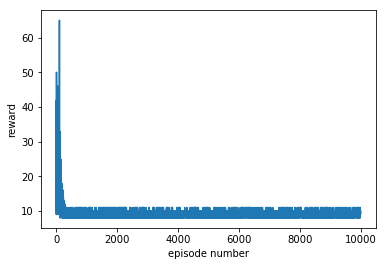

In [343]:
env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5
n_episodes = 10000

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

rewards_per_episode = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    #if i % 10 == 0:
    print('episode:', i,
          'R:', R,
          'statistics:', agent.get_statistics()
         )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')
plt.plot(rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward")

Discrete(4)


/home/galias/miniconda2/envs/gym/lib/python3.6/site-packages/chainer/functions/math/exponential.py:51: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),


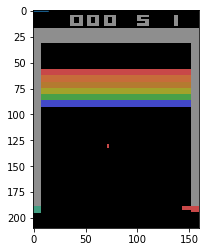

In [331]:
env = gym.make('Breakout-v0')
print(env.action_space)
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape([-1] + list(x.shape))
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

# print("states actions rewards value_preds returns")

obs = env.reset()
reward = 0
done = False
R = []

for _ in range(15):
    plt.imshow(env.render(mode='rgb_array'))
    action = agent.act_and_train(obs, reward, done)
    _obs, reward, done, _ = env.step(action)
    obs = _obs
    R.append(reward)
    if done:
        obs = env.reset()
        reward = 0
        done = False
plt.plot(np.cumsum(R))

In [ ]:
import logging
import sys
gym.undo_logger_setup()  # Turn off gym's default logger settings
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

chainerrl.experiments.train_agent_with_evaluation(
    agent, env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_runs=10,       # 10 episodes are sampled for each evaluation
    max_episode_len=200,  # Maximum length of each episodes
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result')      # Save everything to 'result' directory

example qfunction (?)

In [ ]:
import chainer 
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

from chainer import cuda

import datetime
from skimage.color import rgb2gray
from skimage.transform import resize

env = gym.make('Breakout-v0')
obs = env.reset()

print("observation space   : {}".format(env.observation_space))
print("action space        : {}".format(env.action_space))

action = env.action_space.sample()
obs, r, done, info = env.step(action)
class QFunction(chainer.Chain):
def __init__(self,obs_size, n_action):
    super(QFunction, self).__init__(
        l1=L.Convolution2D(obs_size, 4, ksize=2,pad=1),#210x160
        bn1=L.BatchNormalization(4),
        l2=L.Convolution2D(4, 4, ksize=2,pad=1),#105x80
        bn2=L.BatchNormalization(4),
        #l3=L.Convolution2D(64, 64, ksize=2, pad=1),#100x100
        #bn3=L.BatchNormalization(64),
        #l4=L.Convolution2D(64, 3, ksize=2,pad=1),#50x50
       # bn4=L.BatchNormalization(3),

        l5=L.Linear(972, 512),
        out=L.Linear(512, n_action, initialW=np.zeros((n_action, 512), dtype=np.float32))
    )

def __call__(self, x, test=False):

    h1=F.relu(self.bn1(self.l1(x)))
    h2=F.max_pooling_2d(F.relu(self.bn2(self.l2(h1))),2)
    #h3=F.relu(self.bn3(self.l3(h2)))
    #h4=F.max_pooling_2d(F.relu(self.bn4(self.l4(h3))),2)
    #print h4.shape

    return chainerrl.action_value.DiscreteActionValue(self.out(self.l5(h2)))

n_action = env.action_space.n
obs_size = env.observation_space.shape[0] #(210,160,3)
q_func = QFunction(obs_size, n_action)

optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

gamma = 0.99

explorer = chainerrl.explorers.ConstantEpsilonGreedy(
epsilon=0.2, random_action_func=env.action_space.sample)

replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

phi = lambda x: x.astype(np.float32, copy=False)
agent = chainerrl.agents.DoubleDQN(
q_func, optimizer, replay_buffer, gamma, explorer,
minibatch_size=4, replay_start_size=100, update_interval=10,
target_update_interval=10, phi=phi)

last_time = datetime.datetime.now()
n_episodes = 10000
for i in range(1, n_episodes + 1):
obs = env.reset()

reward = 0
done = False
R = 0

while not done:
    env.render()
    action = agent.act_and_train(obs, reward)
    obs, reward, done, _ = env.step(action)


    if reward != 0:
        R += reward

elapsed_time = datetime.datetime.now() - last_time
print('episode:', i, 
      'reward:', R,
     )
last_time = datetime.datetime.now()

if i % 100 == 0:
    filename = 'agent_Breakout' + str(i)
    agent.save(filename)

agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

In [29]:
class CNN(chainer.Chain):
    
    def __init__(self, train=True):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 1, 1, initialW=np.array([[[[1]]]])) ,
            l1 = L.Linear(None, 1, initialW=np.array([[1,1,1,1]]))  
        )

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.sigmoid(self.l1(h))
        return h


net = CNN()
net.cleargrads()
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)

optimizer.setup(net)
net.conv1.W.update_rule.enabled = False
# net.conv1.disable_update()  # also works

result = net(np.random.random((1,1,2,2)).astype(np.float32))
print("conv1 weights:",net.conv1.W.data)
print("l1 weigths:",net.l1.W.data)
loss = F.mean_absolute_error(result,np.array([[0.1]],dtype=np.float32))
loss.backward()
optimizer.update()
print("conv1 grad",net.conv1.W.grad)
print("after update...")
print("conv1 weights:",net.conv1.W.data)
print("l1 weights:",net.l1.W.data)

conv1 weights: [[[[ 1.]]]]
l1 weigths: [[ 1.  1.  1.  1.]]
conv1 grad [[[[ 0.19457532]]]]
after update...
conv1 weights: [[[[ 1.]]]]
l1 weights: [[ 0.99955279  0.99984294  0.99892896  0.99972951]]


pyTorch tutorial